## Misuse/Signature Detection

### Introduction
Globally, Security of computers and the networks that connect them is increasingly becoming of great
significance. Attacks on the nation’s computer infrastructures are becoming an increasingly serious problem.
Computer security is defined as the protection of computing systems against threats to confidentiality, integrity,
and availability. A signature detection system identifies patterns of traffic or application data presumed to be
malicious

### Objective
Analyze the data set, investigate and
evaluate the result and predict the overall performance.

### Tasks in this assignment
1) Write a Data Science Proposal for achieving the objective mentioned.  
2) Perform exploratory analysis on the data and describe your understanding of the data.  
3) Perform data wrangling / pre-processing (Module 8). (missing data, normalization, discretization, etc)  
4) Apply any two feature selection engineering techniques (Module 8)  
5) Compare the two selected feature engineering techniques.  
6) Plot top 5, 6, and 8 features.  
7) Provide a high-level description of Machine Learning models – SVM and Decision tree to predict.  
8) Compare the performance of the two classifiers – SVM and Decision tree to predict.  
9) Present the conclusions/results in the format shared.  
10) Any suggestion on the identification of the performance parameters to be improved, for the given classification problem.  

### Notebook Initialization

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import scipy as scipy
import matplotlib as matplot
import matplotlib.pyplot as plt

from sklearn import svm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import VarianceThreshold
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.precision", 4)
np.random.seed(2021)

#### NOTE:
This notebook uses the below mentioned versions of the following libraries.  
So please have your libraries updated in order to execute this notebook.  
- numpy: 1.19.5
- pandas: 1.19.5
- seaborn: 0.11.1
- sklearn: 0.24.0
- matplotlib: 3.3.3
- scipy: 1.6.0

#### Read the dataset

In [2]:
signature_original_dataframe = pd.read_csv("signature-dataset.csv")
df = signature_original_dataframe.copy()

### Exploratory Data Analysis

In [3]:
print("df.shape:", df.shape)
# the dataset has 40 attributes and 22544 records
print()
print(df.info())

df.shape: (22544, 40)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22544 entries, 0 to 22543
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     22544 non-null  int64  
 1   protocol_type                22544 non-null  object 
 2   service                      22544 non-null  object 
 3   flag                         22544 non-null  object 
 4   src_bytes                    22544 non-null  int64  
 5   dst_bytes                    22544 non-null  int64  
 6   land                         22544 non-null  int64  
 7   wrong_fragment               22544 non-null  int64  
 8   urgent                       22544 non-null  int64  
 9   hot                          22544 non-null  int64  
 10  num_failed_logins            22544 non-null  int64  
 11  logged_in                    22544 non-null  int64  
 12  num_compromised              22544 non-null  int64 

#### OBSERVATIONS:
- total number of records in the given dataset is 22544.
- protocol_type, service and flag attributes are of nominal type  
- <b>class</b> attribute is the target attribute    
- <b>count</b> and <b>srv_count</b> attributes have missing values
- some of the numerical attributes are of int type and rest of them are of float type

#### Lets count the number of missing data points across the various attributes 

In [4]:
df.isnull().sum().sort_values(ascending = False)

count                          18
srv_count                      13
dst_host_srv_rerror_rate        0
dst_host_rerror_rate            0
serror_rate                     0
srv_serror_rate                 0
rerror_rate                     0
srv_rerror_rate                 0
same_srv_rate                   0
diff_srv_rate                   0
srv_diff_host_rate              0
dst_host_count                  0
protocol_type                   0
dst_host_same_srv_rate          0
dst_host_diff_srv_rate          0
dst_host_same_src_port_rate     0
dst_host_srv_diff_host_rate     0
dst_host_serror_rate            0
dst_host_srv_serror_rate        0
dst_host_srv_count              0
duration                        0
is_guest_login                  0
hot                             0
service                         0
flag                            0
src_bytes                       0
dst_bytes                       0
land                            0
wrong_fragment                  0
urgent        

#### OBSERVATIONS:
- <b>count</b> attribute has 18 missing points
- <b>srv_count</b> attribute has 13 missing points

#### Lets see the target variable carefully
In the given dataset, the target variable is a categorical attribute.

In [5]:
df['class'].value_counts(sort=True)

anomaly    12833
normal      9711
Name: class, dtype: int64

#### OBSERVATIONS:
- The target variable <b>class</b> has only two unique values: <b>anomaly</b> and <b>normal</b>  
- Target variable is a symmetric categorical attribute.

### Data Preprocessing

#### Lets seggregate the numerical and categorical features
Now we have two datasets for numerical and categorical features.  
- <b>numerical_features_df</b>
- <b>categorical_features_df</b>  

<b>This classification is preliminary and can be updated or modified later.</b>

#### Approach for handling the missing values for numerical attributes
Since the target label has no missing data, so we can find out the mean of the numerical attributes corresponding to each class, and then can replace the missing data with that mean value altogether.

Since we have two features (count and srv_count) which have missing values, so lets analyze them first.

In [6]:
def replace_with_mean_per_class(attr):
    attr_mean_per_class = df.loc[:, [attr, 'class']].groupby(by=['class']).mean()
    attr_and_class = df.loc[:, [attr, 'class']]
    attr_and_class[attr] = np.where(attr_and_class['class'] == 'anomaly', 
                                attr_and_class[attr].fillna(attr_mean_per_class.loc['anomaly', attr]),
                                attr_and_class[attr].fillna(attr_mean_per_class.loc['normal', attr]))
    df[attr] = attr_and_class[attr]

In [7]:
print("Describing count attribute:")
print(df['count'].describe())
print()
print("Describing srv_count attribute:")
print(df['srv_count'].describe())

Describing count attribute:
count    22526.0000
mean        79.0168
std        128.5458
min          0.0000
25%          1.0000
50%          8.0000
75%        123.0000
max        511.0000
Name: count, dtype: float64

Describing srv_count attribute:
count    22531.0000
mean        31.1075
std         89.0273
min          0.0000
25%          1.0000
50%          6.0000
75%         16.0000
max        511.0000
Name: srv_count, dtype: float64


#### OBSERVATIONS:
- The mean for 'count' and 'srv_count' with the missing values are 79.0168 and 31.1075 respectively.

In [8]:
_ = replace_with_mean_per_class('count')
_ = replace_with_mean_per_class('srv_count')

In [9]:
print("Describing count attribute:")
print(df['count'].describe())
print()
print("Describing srv_count attribute:")
print(df['srv_count'].describe())

Describing count attribute:
count    22544.0000
mean        79.0160
std        128.4985
min          0.0000
25%          1.0000
50%          8.0000
75%        123.0000
max        511.0000
Name: count, dtype: float64

Describing srv_count attribute:
count    22544.0000
mean        31.1086
std         89.0018
min          0.0000
25%          1.0000
50%          6.0000
75%         16.0000
max        511.0000
Name: srv_count, dtype: float64


#### OBSERVATIONS:
- The mean for 'count' and 'srv_count' without the missing values are 79.0160 and 31.1086 respectively.

#### Data Types Conversion
Lets convert the datatypes for each numerical attribute (int or float datatype) to the float type in order to proceed with further EDA.

In [10]:
df['duration'] = df['duration'].astype('float64')
df['src_bytes'] = df['src_bytes'].astype('float64')
df['dst_bytes'] = df['dst_bytes'].astype('float64')
df['land'] = df['land'].astype('float64')
df['wrong_fragment'] = df['wrong_fragment'].astype('float64')

df['urgent'] = df['urgent'].astype('float64')
df['hot'] = df['hot'].astype('float64')
df['num_failed_logins'] = df['num_failed_logins'].astype('float64')
df['logged_in'] = df['logged_in'].astype('float64')
df['num_compromised'] = df['num_compromised'].astype('float64')

df['root_shell'] = df['root_shell'].astype('float64')
df['su_attempted'] = df['su_attempted'].astype('float64')
df['num_root'] = df['num_root'].astype('float64')
df['num_file_creations'] = df['num_file_creations'].astype('float64')
df['num_shells'] = df['num_shells'].astype('float64')

df['num_access_files'] = df['num_access_files'].astype('float64')
df['is_guest_login'] = df['is_guest_login'].astype('float64')
df['dst_host_count'] = df['dst_host_count'].astype('float64')
df['dst_host_srv_count'] = df['dst_host_srv_count'].astype('float64')

# print(df.info())

### Lets analyze each attribute
Here we check for the outliers or incompatible values for the attribute, and then address these issues.

In [11]:
def showFeatureInfo(attr):
    print('Feature Info:')
    q1 = df[attr].quantile(0.25)
    q3 = df[attr].quantile(0.75)
    iqr = q3 - q1
    lower_whisker = q1 - 1.5*iqr
    upper_whisker = q3 + 1.5*iqr
    print('MIN :', df[attr].min())
    print('MAX :', df[attr].max())
    print('MEAN :', df[attr].mean())
    print('Std Deviation :', df[attr].std())
    print('Q1 :', q1)
    print('Q3 :', q3)
    print('IQR :', iqr)
    print('LowerWhisker :', lower_whisker)
    print('UpperWhisker :', upper_whisker)

In [12]:
def analyzeTheFeature(attr):
    _ = showFeatureInfo(attr)
    ndf = df[attr]
    fig, ax = plt.subplots(1, 3, figsize=(12,4))
    _ = sns.distplot(ndf, bins=50, kde=True, ax=ax[0])
    _ = sns.boxplot(ndf, ax=ax[1])
    _ = ndf.hist(ax=ax[2])
    fig.show()

We will consider the data points as outliers if they fall behind or beyond the <b>3 times of the negative or positive std deviation</b> respectively.

In [13]:
def removeTheOutliersUsingSD(attr):
    df_attr_std = df[attr].std()
    lower_bound = -3*df_attr_std
    upper_bound = +3*df_attr_std
    df[attr] = np.where(df[attr].between(lower_bound, upper_bound), df[attr], np.nan)
    df_attr_mean = df[attr].mean()
    df[attr] = df[attr].replace(np.nan, df_attr_mean)

We will consider the data points as outliers if they fall behind or beyond the <b>1.5 times of the IQR</b> respectively.

In [14]:
def removeTheOutliersUsingIQR(attr):
    q1 = df[attr].quantile(0.25)
    q3 = df[attr].quantile(0.75)
    iqr = q3 - q1
    lw = q1 - 1.5*iqr
    uw = q3 + 1.5*iqr
    ndf_new = df[attr][df[attr] < uw]
    df[attr] = ndf_new[ndf_new > lw]
    _ = replace_with_mean_per_class(attr)

In [15]:
def standardizeTheFeature(attr):
    attr_mean = df[attr].mean()
    attr_std = df[attr].std()
    df[attr] = ((df[attr] - attr_mean)/attr_std)

In [16]:
def normalizeTheFeature(attr):
    attr_min = df[attr].min()
    attr_max = df[attr].max()
    attr_diff = (attr_max - attr_min)
    df[attr] = ((df[attr] - attr_min)/attr_diff)

#### Attribute: duration

Feature Info:
MIN : 0.0
MAX : 57715.0
MEAN : 218.85907558552165
Std Deviation : 1407.1766119045014
Q1 : 0.0
Q3 : 0.0
IQR : 0.0
LowerWhisker : 0.0
UpperWhisker : 0.0


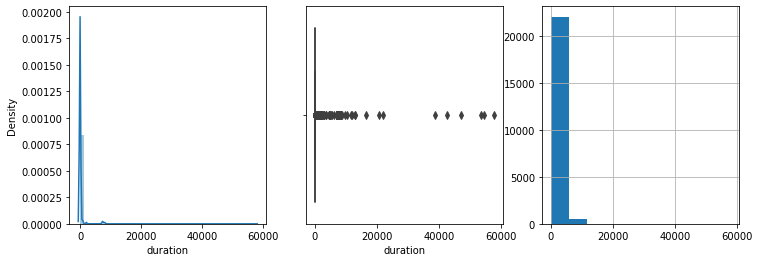

In [17]:
_ = analyzeTheFeature('duration')

In [18]:
df['duration'].value_counts()

0.0        19018
1.0          587
4.0          539
282.0        240
280.0        216
           ...  
54451.0        1
7448.0         1
1578.0         1
50.0           1
433.0          1
Name: duration, Length: 624, dtype: int64

Even though it appears that the <b>duration</b> feature has some outliers.  
But the this feature represents the time duration (in milliseconds) for which the particular request remains active.  

#### Attribute: src_bytes

Feature Info:
MIN : 0.0
MAX : 62825648.0
MEAN : 10395.450230660043
Std Deviation : 472786.43108809966
Q1 : 0.0
Q3 : 287.0
IQR : 287.0
LowerWhisker : -430.5
UpperWhisker : 717.5


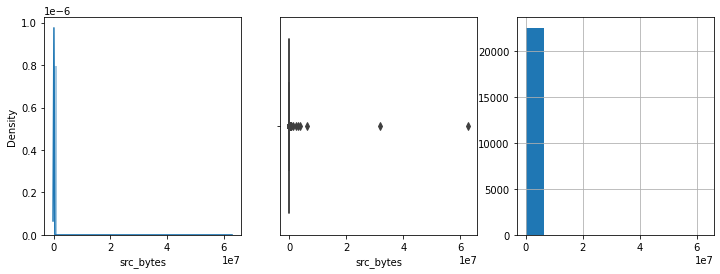

In [19]:
_ = analyzeTheFeature('src_bytes')

<b>src_bytes</b> represents the bytes being sent as payload for the request.  
So, this feature does not qualify for the outliers, because requests without payload would have 0 bytes.

In [20]:
df['src_bytes'].value_counts()

0.0        7626
1.0         473
105.0       362
54540.0     325
44.0        313
           ... 
898.0         1
4763.0        1
1844.0        1
1467.0        1
860.0         1
Name: src_bytes, Length: 1149, dtype: int64

#### Attribute: dst_bytes

Feature Info:
MIN : 0.0
MAX : 1345927.0
MEAN : 2056.0188076650106
Std Deviation : 21219.29760945955
Q1 : 0.0
Q3 : 601.0
IQR : 601.0
LowerWhisker : -901.5
UpperWhisker : 1502.5


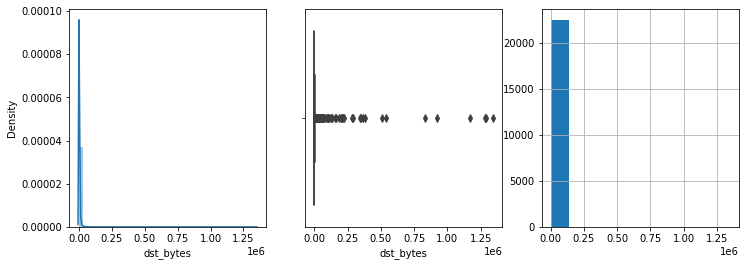

In [21]:
_ = analyzeTheFeature('dst_bytes')

<b>dst_bytes</b> represents the bytes being received as payload for the request.  
So, this feature does not qualify for the outliers, because requests without payload would have 0 bytes.

In [22]:
df['dst_bytes'].value_counts()

0.0       9366
44.0       819
93.0       708
1.0        362
174.0      329
          ... 
7105.0       1
1539.0       1
3398.0       1
6319.0       1
2150.0       1
Name: dst_bytes, Length: 3650, dtype: int64

#### Attribute: land

Feature Info:
MIN : 0.0
MAX : 1.0
MEAN : 0.0003105039034776437
Std Deviation : 0.017618775791094693
Q1 : 0.0
Q3 : 0.0
IQR : 0.0
LowerWhisker : 0.0
UpperWhisker : 0.0


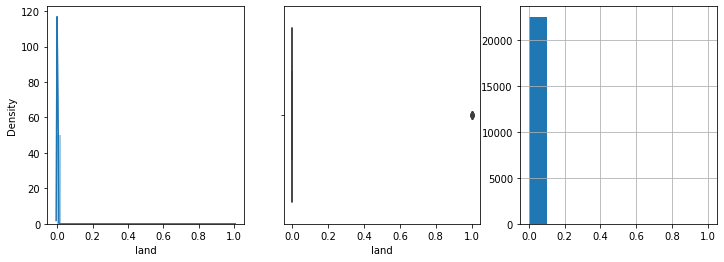

In [23]:
_ = analyzeTheFeature('land')

In [24]:
df['land'].value_counts()

0.0    22537
1.0        7
Name: land, dtype: int64

<b>land</b> attribute has only two unique values, 0 and 1.  
So this must be treated as categorical attribute instead of the numerical attribute.  
Also we must check for its relevance for the further data mining process.

In [25]:
result = df['class'][df['land'] == 1.0]
print("Frequency for value 1.0 :")
print(result)

Frequency for value 1.0 :
4892     anomaly
9471     anomaly
15873    anomaly
18216    anomaly
18530    anomaly
19365    anomaly
20722    anomaly
Name: class, dtype: object


And as we can see that data value <b>1.0</b> of <b>land</b> only ends with the <b>anomaly</b> category.  
This leaves us with only one instance of target variable for the data value <b>0.0</b> of <b>land</b>.  
##### So it would be wise to ignore the land feature for the rest of the mining process.

#### Attribute: wrong_fragment

Feature Info:
MIN : 0.0
MAX : 3.0
MEAN : 0.008427963094393186
Std Deviation : 0.14259878559946115
Q1 : 0.0
Q3 : 0.0
IQR : 0.0
LowerWhisker : 0.0
UpperWhisker : 0.0


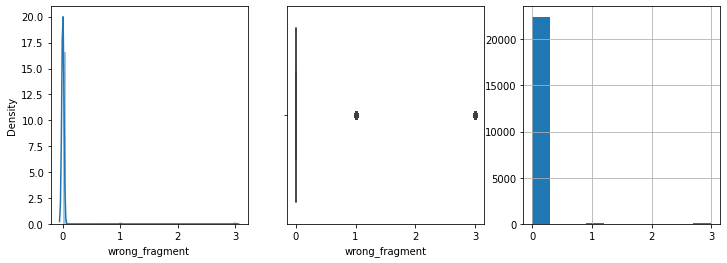

In [26]:
_ = analyzeTheFeature('wrong_fragment')

In [27]:
df['wrong_fragment'].value_counts()

0.0    22444
1.0       55
3.0       45
Name: wrong_fragment, dtype: int64

<b>wrong_fragment</b> attribute has only three unique values, 0, 1 and 3.  
So this must be treated as categorical attribute instead of the numerical attribute.

#### Attribute: urgent

Feature Info:
MIN : 0.0
MAX : 3.0
MEAN : 0.0007097232079489
Std Deviation : 0.03647309030387034
Q1 : 0.0
Q3 : 0.0
IQR : 0.0
LowerWhisker : 0.0
UpperWhisker : 0.0


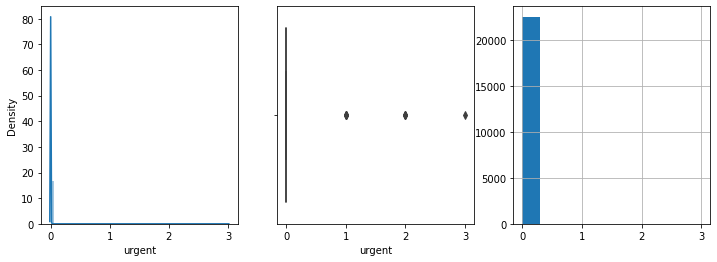

In [28]:
_ = analyzeTheFeature('urgent')

In [29]:
df['urgent'].value_counts()

0.0    22534
1.0        5
2.0        4
3.0        1
Name: urgent, dtype: int64

<b>urgent</b> attribute has only four unique values, 0, 1, 2 and 3.  
So this must be treated as categorical attribute instead of the numerical attribute.  
Also we must check for its relevance for the further data mining process.

In [30]:
result = df['class'][df['urgent'] == 1.0]
print("Frequency for value 1.0 :")
print(result)

result = df['class'][df['urgent'] == 2.0]
print("Frequency for value 2.0 :")
print(result)

result = df['class'][df['urgent'] == 3.0]
print("Frequency for value 3.0 :")
print(result)

Frequency for value 1.0 :
2745     anomaly
3621     anomaly
5478     anomaly
8125     anomaly
19346    anomaly
Name: class, dtype: object
Frequency for value 2.0 :
8766     anomaly
9082     anomaly
12530    anomaly
18862    anomaly
Name: class, dtype: object
Frequency for value 3.0 :
10995    anomaly
Name: class, dtype: object


And as we can see that data value <b>1.0</b>, <b>2.0</b> and <b>3.0</b> of <b>urgent</b> only ends with the <b>anomaly</b> category.  
This leaves us with only one instance of target variable for the data value <b>0.0</b> of <b>urgent</b>.  
##### So it would be wise to ignore the urgent feature for the rest of the mining process.

#### Attribute: hot

Feature Info:
MIN : 0.0
MAX : 101.0
MEAN : 0.10539389638041163
Std Deviation : 0.9284280387695629
Q1 : 0.0
Q3 : 0.0
IQR : 0.0
LowerWhisker : 0.0
UpperWhisker : 0.0


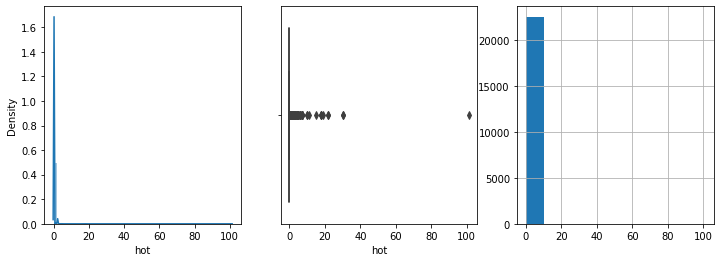

In [31]:
_ = analyzeTheFeature('hot')

In [32]:
df['hot'].value_counts()

0.0      21537
2.0        846
1.0         90
4.0         20
3.0         12
5.0         11
7.0          9
6.0          6
18.0         3
30.0         2
22.0         2
10.0         2
19.0         1
15.0         1
11.0         1
101.0        1
Name: hot, dtype: int64

<b>hot</b> appears to be a numerical attribute as it has so many unique values.  
Also, it does have some outliers which must be carefully dealt with.

In [33]:
_ = removeTheOutliersUsingSD('hot')

In [34]:
df['hot'].value_counts()

0.0000    21537
2.0000      846
1.0000       90
0.0793       71
Name: hot, dtype: int64

#### Attribute: num_failed_logins

Feature Info:
MIN : 0.0
MAX : 4.0
MEAN : 0.021646557842441447
Std Deviation : 0.15032775261555983
Q1 : 0.0
Q3 : 0.0
IQR : 0.0
LowerWhisker : 0.0
UpperWhisker : 0.0


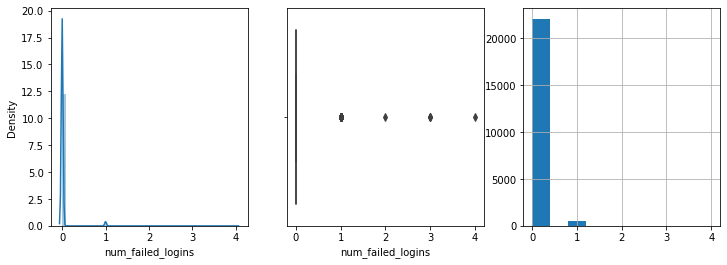

In [35]:
_ = analyzeTheFeature('num_failed_logins')

In [36]:
df['num_failed_logins'].value_counts()

0.0    22066
1.0      473
3.0        3
4.0        1
2.0        1
Name: num_failed_logins, dtype: int64

<b>num_failed_logins</b> attribute has only five unique values, 0, 1, 2, 3 and 4.  
So this must be treated as categorical attribute instead of the numerical attribute.

#### Attribute: logged_in

Feature Info:
MIN : 0.0
MAX : 1.0
MEAN : 0.4422019162526615
Std Deviation : 0.4966591620452154
Q1 : 0.0
Q3 : 1.0
IQR : 1.0
LowerWhisker : -1.5
UpperWhisker : 2.5


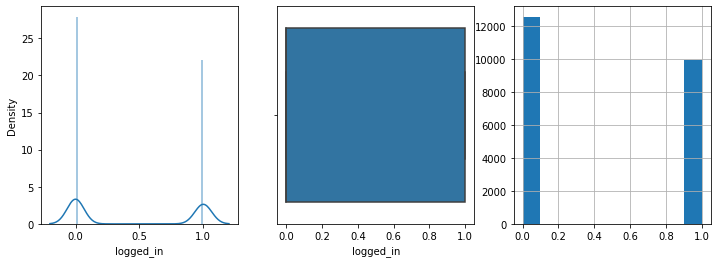

In [37]:
_ = analyzeTheFeature('logged_in')

In [38]:
df['logged_in'].value_counts()

0.0    12575
1.0     9969
Name: logged_in, dtype: int64

<b>logged_in</b> attribute has only two unique values, 0 and 1.  
So this must be treated as categorical attribute instead of the numerical attribute.

#### Attribute: num_compromised

Feature Info:
MIN : 0.0
MAX : 796.0
MEAN : 0.11989886444286728
Std Deviation : 7.269597239268335
Q1 : 0.0
Q3 : 0.0
IQR : 0.0
LowerWhisker : 0.0
UpperWhisker : 0.0


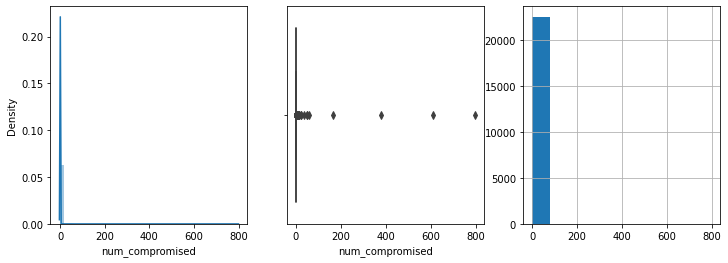

In [39]:
_ = analyzeTheFeature('num_compromised')

In [40]:
df['num_compromised'].value_counts()

0.0      22175
1.0        325
2.0         11
4.0          4
8.0          4
3.0          3
5.0          3
14.0         2
49.0         2
6.0          2
9.0          1
57.0         1
36.0         1
10.0         1
11.0         1
15.0         1
381.0        1
25.0         1
796.0        1
165.0        1
7.0          1
23.0         1
611.0        1
Name: num_compromised, dtype: int64

In [41]:
_ = removeTheOutliersUsingSD('num_compromised')

In [42]:
df['num_compromised'].value_counts()

0.0000     22175
1.0000       325
2.0000        11
0.0227        10
4.0000         4
8.0000         4
3.0000         3
5.0000         3
14.0000        2
6.0000         2
7.0000         1
15.0000        1
9.0000         1
11.0000        1
10.0000        1
Name: num_compromised, dtype: int64

#### Attribute: root_shell

Feature Info:
MIN : 0.0
MAX : 1.0
MEAN : 0.0024396735273243433
Std Deviation : 0.049333857334324945
Q1 : 0.0
Q3 : 0.0
IQR : 0.0
LowerWhisker : 0.0
UpperWhisker : 0.0


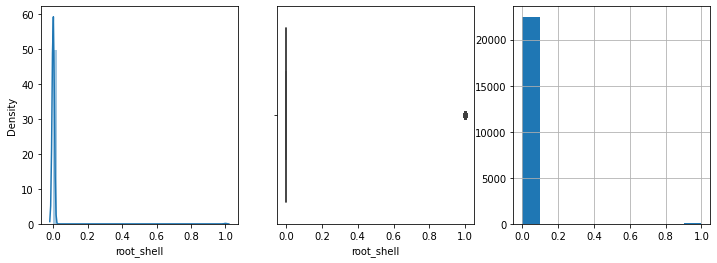

In [43]:
_ = analyzeTheFeature('root_shell')

In [44]:
df['root_shell'].value_counts()

0.0    22489
1.0       55
Name: root_shell, dtype: int64

<b>root_shell</b> attribute has only two unique values, 0 and 1.  
So this must be treated as categorical attribute instead of the numerical attribute.

#### Attribute: su_attempted

Feature Info:
MIN : 0.0
MAX : 2.0
MEAN : 0.00026614620298083747
Std Deviation : 0.021060053298918652
Q1 : 0.0
Q3 : 0.0
IQR : 0.0
LowerWhisker : 0.0
UpperWhisker : 0.0


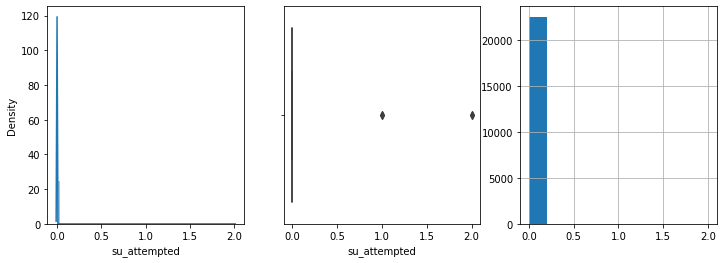

In [45]:
_ = analyzeTheFeature('su_attempted')

In [46]:
df['su_attempted'].value_counts()

0.0    22540
2.0        2
1.0        2
Name: su_attempted, dtype: int64

<b>su_attempted</b> attribute has only 3 unique values, 0, 1 and 2.  
And out of these three unique values, the frequency for values 1 and 2 is just 2.  

In [47]:
result = df['class'][df['su_attempted'] == 1.0]
print("Frequency for value 1.0 :")
print(result)
print()
result = df['class'][df['su_attempted'] == 2.0]
print("Frequency for value 2.0 :")
print(result)

Frequency for value 1.0 :
11462     normal
16961    anomaly
Name: class, dtype: object

Frequency for value 2.0 :
384      normal
13293    normal
Name: class, dtype: object


And as we can see that data value <b>2.0</b> of <b>su_attempted</b> only ends with the <b>normal</b> category.  
This leaves us with only two instance of target variable for the data value <b>1.0</b> of <b>su_attempted</b>.  
##### So it would be wise to ignore the su_attempted feature for the rest of the mining process.

#### Attribute: num_root

Feature Info:
MIN : 0.0
MAX : 878.0
MEAN : 0.11466465578424415
Std Deviation : 8.041613677729387
Q1 : 0.0
Q3 : 0.0
IQR : 0.0
LowerWhisker : 0.0
UpperWhisker : 0.0


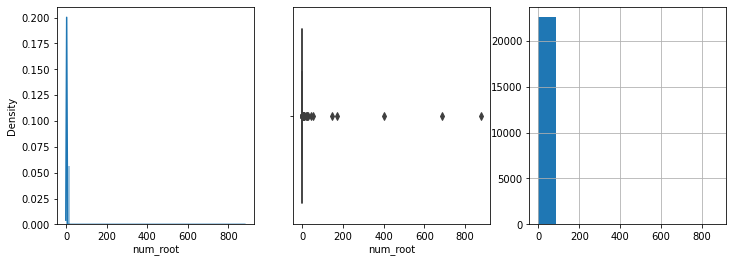

In [48]:
_ = analyzeTheFeature('num_root')

In [49]:
df['num_root'].value_counts()

0.0      22496
1.0         14
3.0          7
4.0          6
2.0          4
7.0          2
8.0          2
878.0        1
9.0          1
173.0        1
31.0         1
145.0        1
45.0         1
5.0          1
26.0         1
17.0         1
401.0        1
51.0         1
23.0         1
684.0        1
Name: num_root, dtype: int64

<b>num_root</b> appears to be a numerical attribute as it has so many unique values.  
Also, it does have some outliers which must be carefully dealt with.

In [50]:
_ = removeTheOutliersUsingSD('num_root')

In [51]:
df['num_root'].value_counts()

0.0000     22496
1.0000        14
0.0067         9
3.0000         7
4.0000         6
2.0000         4
8.0000         2
7.0000         2
23.0000        1
5.0000         1
17.0000        1
9.0000         1
Name: num_root, dtype: int64

#### Attribute: num_file_creations

Feature Info:
MIN : 0.0
MAX : 100.0
MEAN : 0.00873846699787083
Std Deviation : 0.6768416716916976
Q1 : 0.0
Q3 : 0.0
IQR : 0.0
LowerWhisker : 0.0
UpperWhisker : 0.0


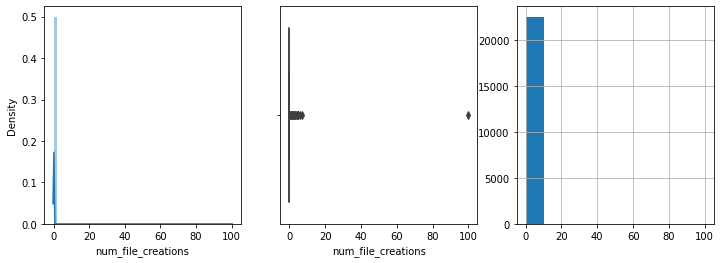

In [52]:
_ = analyzeTheFeature('num_file_creations')

In [53]:
df['num_file_creations'].value_counts()

0.0      22502
1.0         17
2.0          9
4.0          6
3.0          5
5.0          2
7.0          1
100.0        1
6.0          1
Name: num_file_creations, dtype: int64

<b>num_file_creations</b> appears to be a numerical attribute as it has so many unique values.  
Also, it does have some outliers which must be carefully dealt with.

In [54]:
_ = removeTheOutliersUsingSD('num_file_creations')

In [55]:
df['num_file_creations'].value_counts()

0.0000    22502
1.0000       17
0.0016       16
2.0000        9
Name: num_file_creations, dtype: int64

#### Attribute: num_shells

Feature Info:
MIN : 0.0
MAX : 5.0
MEAN : 0.0011533002129169624
Std Deviation : 0.04801429563660692
Q1 : 0.0
Q3 : 0.0
IQR : 0.0
LowerWhisker : 0.0
UpperWhisker : 0.0


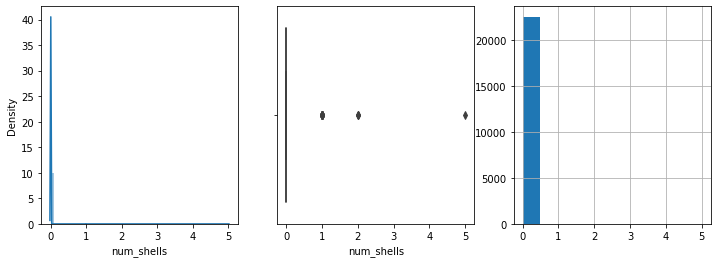

In [56]:
_ = analyzeTheFeature('num_shells')

In [57]:
df['num_shells'].value_counts()

0.0    22525
1.0       15
2.0        3
5.0        1
Name: num_shells, dtype: int64

<b>num_shells</b> attribute has only four unique values, 0, 1, 2 and 5.  
So this must be treated as categorical attribute instead of the numerical attribute.

In [58]:
result = df['class'][df['num_shells'] == 1.0]
print("Frequency for value 1.0 :")
print(result)

result = df['class'][df['num_shells'] == 2.0]
print("Frequency for value 2.0 :")
print(result)

result = df['class'][df['num_shells'] == 5.0]
print("Frequency for value 5.0 :")
print(result)

Frequency for value 1.0 :
106      anomaly
2421     anomaly
3621     anomaly
4167     anomaly
5478     anomaly
8125     anomaly
9596     anomaly
11404    anomaly
12486    anomaly
12525    anomaly
16961    anomaly
17567    anomaly
20555    anomaly
20894    anomaly
22085    anomaly
Name: class, dtype: object
Frequency for value 2.0 :
2036     anomaly
4500     anomaly
21553    anomaly
Name: class, dtype: object
Frequency for value 5.0 :
20734    anomaly
Name: class, dtype: object


And as we can see that data value <b>1.0</b>, <b>2.0</b> and <b>5.0</b> of <b>num_shells</b> only ends with the <b>anomaly</b> category.  
This leaves us with only one instance of target variable for the data value <b>0.0</b> of <b>num_shells</b>.  
##### So it would be wise to ignore the num_shells feature for the rest of the mining process.

#### Attribute: num_access_files

Feature Info:
MIN : 0.0
MAX : 4.0
MEAN : 0.0035486160397444995
Std Deviation : 0.06782928760736376
Q1 : 0.0
Q3 : 0.0
IQR : 0.0
LowerWhisker : 0.0
UpperWhisker : 0.0


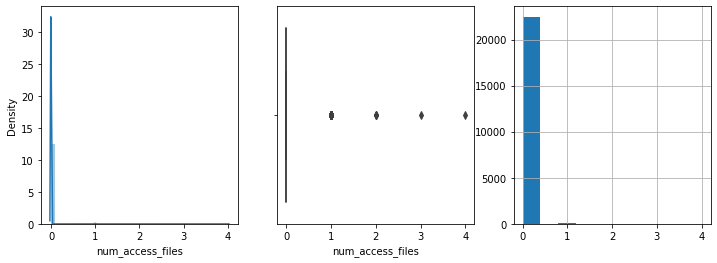

In [59]:
_ = analyzeTheFeature('num_access_files')

In [60]:
df['num_access_files'].value_counts()

0.0    22472
1.0       67
2.0        3
4.0        1
3.0        1
Name: num_access_files, dtype: int64

<b>num_access_files</b> attribute has only five unique values, 0, 1, 2, 3 and 4.  
So this must be treated as categorical attribute instead of the numerical attribute.

#### Attribute: is_guest_login

Feature Info:
MIN : 0.0
MAX : 1.0
MEAN : 0.028433286018452804
Std Deviation : 0.1662108892134551
Q1 : 0.0
Q3 : 0.0
IQR : 0.0
LowerWhisker : 0.0
UpperWhisker : 0.0


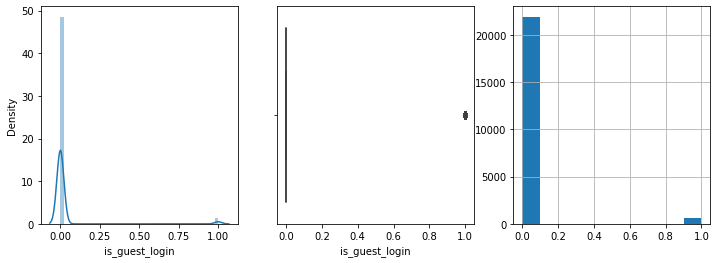

In [61]:
_ = analyzeTheFeature('is_guest_login')

In [62]:
df['is_guest_login'].value_counts()

0.0    21903
1.0      641
Name: is_guest_login, dtype: int64

<b>is_guest_login</b> attribute has only two unique values, 0 and 1.  
So this must be treated as categorical attribute instead of the numerical attribute.

#### Attribute: count

Feature Info:
MIN : 0.0
MAX : 511.0
MEAN : 79.01602631122667
Std Deviation : 128.49854653602682
Q1 : 1.0
Q3 : 123.0
IQR : 122.0
LowerWhisker : -182.0
UpperWhisker : 306.0


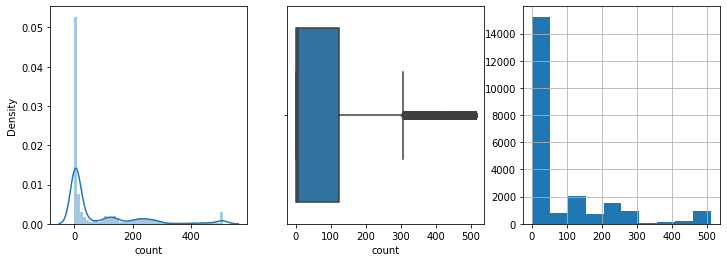

In [63]:
_ = analyzeTheFeature('count')

In [64]:
df['count'].value_counts()

1.0      5816
2.0      1776
3.0      1295
4.0       931
5.0       616
         ... 
404.0       1
420.0       1
386.0       1
419.0       1
0.0         1
Name: count, Length: 497, dtype: int64

In [65]:
_ = removeTheOutliersUsingSD('count')

In [66]:
df['count'].value_counts()

1.0000      5816
2.0000      1776
3.0000      1295
56.5434     1183
4.0000       931
            ... 
356.0000       1
364.0000       1
306.0000       1
384.0000       1
0.0000         1
Name: count, Length: 380, dtype: int64

#### Attribute: srv_count

Feature Info:
MIN : 0.0
MAX : 511.0
MEAN : 31.108552828885664
Std Deviation : 89.00182771009057
Q1 : 1.0
Q3 : 16.0
IQR : 15.0
LowerWhisker : -21.5
UpperWhisker : 38.5


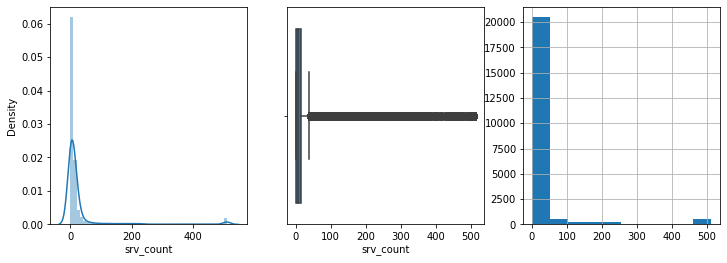

In [67]:
_ = analyzeTheFeature('srv_count')

In [68]:
df['srv_count'].value_counts()

1.0      5941
2.0      1911
3.0      1400
4.0      1048
5.0       874
         ... 
478.0       1
263.0       1
375.0       1
272.0       1
0.0         1
Name: srv_count, Length: 459, dtype: int64

In [69]:
_ = removeTheOutliersUsingSD('srv_count')

In [70]:
df['srv_count'].value_counts()

1.0      5941
2.0      1911
3.0      1400
4.0      1048
5.0       874
         ... 
134.0       1
251.0       1
265.0       1
254.0       1
0.0         1
Name: srv_count, Length: 268, dtype: int64

#### Attribute: serror_rate

Feature Info:
MIN : 0.0
MAX : 1.0
MEAN : 0.1029236160397445
Std Deviation : 0.29536686163330456
Q1 : 0.0
Q3 : 0.0
IQR : 0.0
LowerWhisker : 0.0
UpperWhisker : 0.0


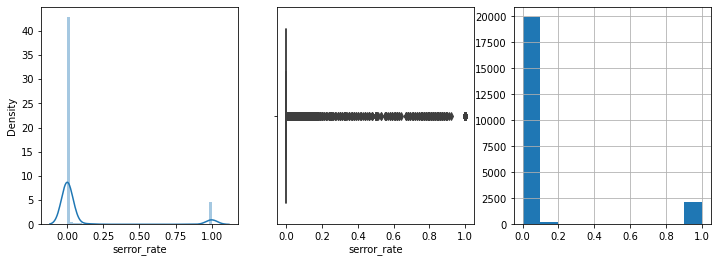

In [71]:
_ = analyzeTheFeature('serror_rate')

In [72]:
df['serror_rate'].value_counts()

0.00    19194
1.00     2104
0.03      104
0.02       94
0.04       90
        ...  
0.23        1
0.70        1
0.43        1
0.57        1
0.36        1
Name: serror_rate, Length: 88, dtype: int64

In [73]:
_ = removeTheOutliersUsingSD('serror_rate')

In [74]:
df['serror_rate'].value_counts()

0.0000    19194
0.0103     2111
0.0300      104
0.0200       94
0.0400       90
          ...  
0.5700        1
0.3600        1
0.7000        1
0.4500        1
0.5100        1
Name: serror_rate, Length: 84, dtype: int64

#### Attribute: srv_serror_rate

Feature Info:
MIN : 0.0
MAX : 1.0
MEAN : 0.10363511355571327
Std Deviation : 0.29833160724158364
Q1 : 0.0
Q3 : 0.0
IQR : 0.0
LowerWhisker : 0.0
UpperWhisker : 0.0


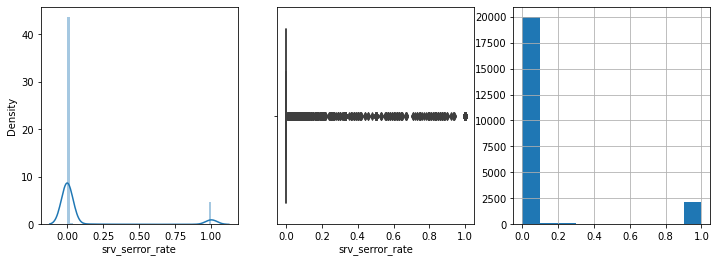

In [75]:
_ = analyzeTheFeature('srv_serror_rate')

In [76]:
df['srv_serror_rate'].value_counts()

0.00    19631
1.00     2165
0.03       81
0.02       60
0.33       42
        ...  
0.31        1
0.37        1
0.76        1
0.93        1
0.35        1
Name: srv_serror_rate, Length: 82, dtype: int64

<b>srv_serror_rate</b> appears to be a numerical attribute as it has so many unique values.  
Also, it does have some outliers which must be carefully dealt with.

In [77]:
_ = removeTheOutliersUsingSD('srv_serror_rate')

In [78]:
df['srv_serror_rate'].value_counts()

0.0000    19631
0.0081     2171
0.0300       81
0.0200       60
0.3300       42
          ...  
0.4800        1
0.3100        1
0.3700        1
0.7600        1
0.3500        1
Name: srv_serror_rate, Length: 78, dtype: int64

#### Attribute: rerror_rate

Feature Info:
MIN : 0.0
MAX : 1.0
MEAN : 0.23846300567778567
Std Deviation : 0.4161176449934063
Q1 : 0.0
Q3 : 0.25
IQR : 0.25
LowerWhisker : -0.375
UpperWhisker : 0.625


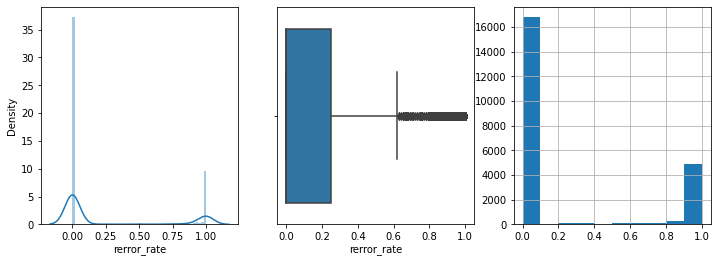

In [79]:
_ = analyzeTheFeature('rerror_rate')

In [80]:
df['rerror_rate'].value_counts()

0.00    16781
1.00     4184
0.97      114
0.50      113
0.98       94
        ...  
0.36        1
0.49        1
0.48        1
0.34        1
0.30        1
Name: rerror_rate, Length: 90, dtype: int64

<b>rerror_rate</b> appears to be a numerical attribute as it has so many unique values.  
Also, it does have some outliers which must be carefully dealt with.

In [81]:
_ = removeTheOutliersUsingSD('rerror_rate')

In [82]:
df['rerror_rate'].value_counts()

0.00    16781
1.00     4184
0.97      114
0.50      113
0.98       94
        ...  
0.36        1
0.49        1
0.48        1
0.34        1
0.30        1
Name: rerror_rate, Length: 90, dtype: int64

#### Attribute: srv_rerror_rate

Feature Info:
MIN : 0.0
MAX : 1.0
MEAN : 0.23517876153300213
Std Deviation : 0.4162149433907463
Q1 : 0.0
Q3 : 0.07250000000000001
IQR : 0.07250000000000001
LowerWhisker : -0.10875000000000001
UpperWhisker : 0.18125000000000002


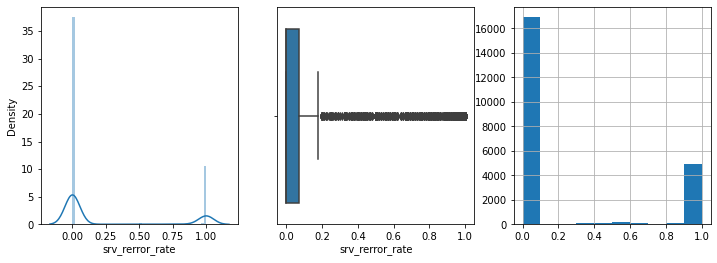

In [83]:
_ = analyzeTheFeature('srv_rerror_rate')

In [84]:
df['srv_rerror_rate'].value_counts()

0.00    16896
1.00     4698
0.50      102
0.97       76
0.67       63
        ...  
0.39        1
0.41        1
0.30        1
0.23        1
0.87        1
Name: srv_rerror_rate, Length: 93, dtype: int64

<b>srv_rerror_rate</b> appears to be a numerical attribute as it has so many unique values.  
Also, it does have some outliers which must be carefully dealt with.  
Also, this feature has two normal bell curves.

In [85]:
_ = removeTheOutliersUsingSD('srv_rerror_rate')

In [86]:
df['srv_rerror_rate'].value_counts()

0.00    16896
1.00     4698
0.50      102
0.97       76
0.67       63
        ...  
0.39        1
0.41        1
0.30        1
0.23        1
0.87        1
Name: srv_rerror_rate, Length: 93, dtype: int64

#### Attribute: same_srv_rate

Feature Info:
MIN : 0.0
MAX : 1.0
MEAN : 0.7403446593328603
Std Deviation : 0.4124960145063593
Q1 : 0.25
Q3 : 1.0
IQR : 0.75
LowerWhisker : -0.875
UpperWhisker : 2.125


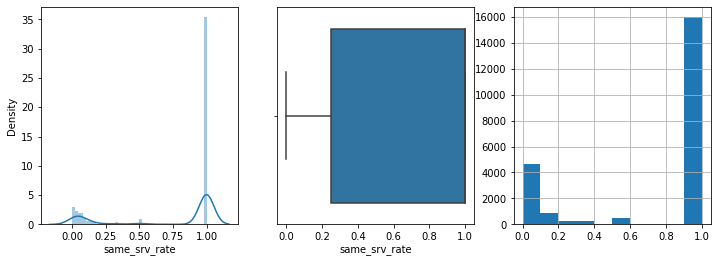

In [87]:
_ = analyzeTheFeature('same_srv_rate')

In [88]:
df['same_srv_rate'].value_counts()

1.00    15860
0.00      744
0.01      632
0.02      510
0.03      487
        ...  
0.54        1
0.57        1
0.65        1
0.94        1
0.58        1
Name: same_srv_rate, Length: 75, dtype: int64

<b>same_srv_rate</b> appears to be a numerical attribute as it has so many unique values.  
But, it does not have any outliers.

#### Attribute: diff_srv_rate

Feature Info:
MIN : 0.0
MAX : 1.0
MEAN : 0.09407381121362669
Std Deviation : 0.259137622121151
Q1 : 0.0
Q3 : 0.06
IQR : 0.06
LowerWhisker : -0.09
UpperWhisker : 0.15


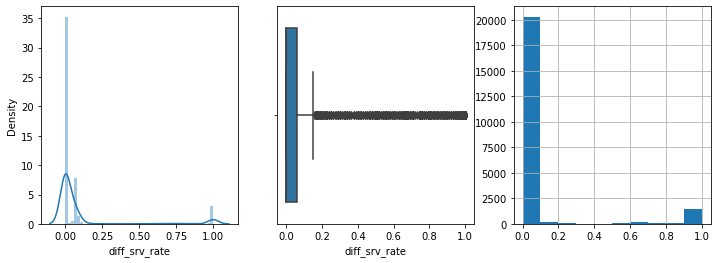

In [89]:
_ = analyzeTheFeature('diff_srv_rate')

In [90]:
df['diff_srv_rate'].value_counts()

0.00    15847
0.06     2200
1.00     1387
0.07     1352
0.08      349
        ...  
0.73        1
0.39        1
0.27        1
0.72        1
0.41        1
Name: diff_srv_rate, Length: 99, dtype: int64

<b>diff_srv_rate</b> appears to be a numerical attribute as it has so many unique values.  
Also, it does have some outliers which must be carefully dealt with.

In [91]:
_ = removeTheOutliersUsingSD('diff_srv_rate')

In [92]:
df['diff_srv_rate'].value_counts()

0.0000    15847
0.0600     2200
0.0274     1567
0.0700     1352
0.0800      349
          ...  
0.3900        1
0.6200        1
0.4100        1
0.7200        1
0.2700        1
Name: diff_srv_rate, Length: 77, dtype: int64

#### Attribute: srv_diff_host_rate

Feature Info:
MIN : 0.0
MAX : 1.0
MEAN : 0.09811036195883605
Std Deviation : 0.2535453005313357
Q1 : 0.0
Q3 : 0.0
IQR : 0.0
LowerWhisker : 0.0
UpperWhisker : 0.0


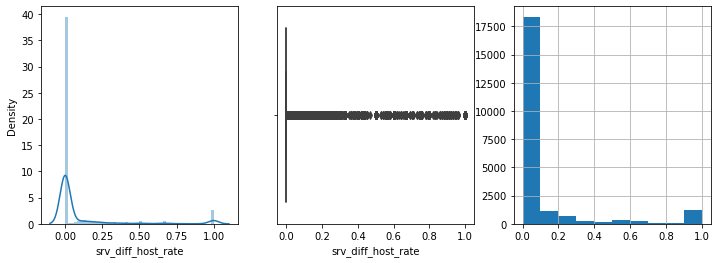

In [93]:
_ = analyzeTheFeature('srv_diff_host_rate')

In [94]:
df['srv_diff_host_rate'].value_counts()

0.00    17569
1.00     1223
0.01      245
0.67      223
0.50      208
        ...  
0.61        1
0.65        1
0.35        1
0.84        1
0.32        1
Name: srv_diff_host_rate, Length: 84, dtype: int64

<b>srv_diff_host_rate</b> appears to be a numerical attribute as it has so many unique values.  
Also, it does have some outliers which must be carefully dealt with.

In [95]:
_ = removeTheOutliersUsingSD('srv_diff_host_rate')

In [96]:
df['srv_diff_host_rate'].value_counts()

0.0000    17569
0.0419     1339
0.0100      245
0.6700      223
0.5000      208
          ...  
0.3500        1
0.6500        1
0.6300        1
0.3900        1
0.4700        1
Name: srv_diff_host_rate, Length: 67, dtype: int64

#### Attribute: dst_host_count

Feature Info:
MIN : 0.0
MAX : 255.0
MEAN : 193.8694109297374
Std Deviation : 94.0356630199968
Q1 : 121.0
Q3 : 255.0
IQR : 134.0
LowerWhisker : -80.0
UpperWhisker : 456.0


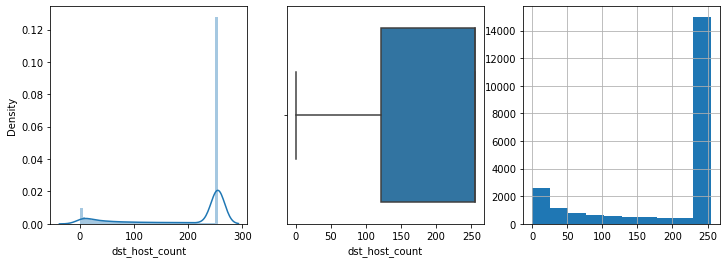

In [97]:
_ = analyzeTheFeature('dst_host_count')

In [98]:
df['dst_host_count'].value_counts()

255.0    14637
1.0        366
2.0        236
3.0        200
4.0        182
         ...  
203.0       10
227.0        7
195.0        7
246.0        7
0.0          1
Name: dst_host_count, Length: 256, dtype: int64

<b>dst_host_count</b> appears to be a numerical attribute as it has so many unique values.  
But, it does not have any outliers.  

#### Attribute: dst_host_srv_count

Feature Info:
MIN : 0.0
MAX : 255.0
MEAN : 140.75053229240595
Std Deviation : 111.7839721699248
Q1 : 15.0
Q3 : 255.0
IQR : 240.0
LowerWhisker : -345.0
UpperWhisker : 615.0


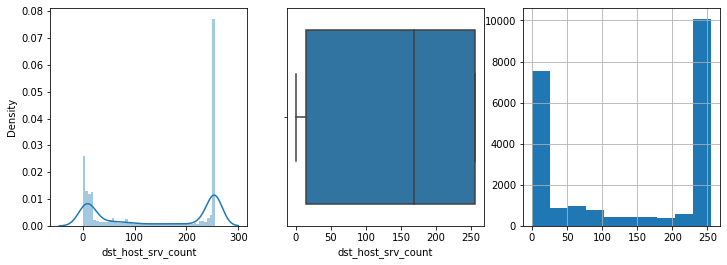

In [99]:
_ = analyzeTheFeature('dst_host_srv_count')

In [100]:
df['dst_host_srv_count'].value_counts()

255.0    7528
1.0      1595
254.0     607
253.0     398
2.0       395
         ... 
207.0      10
112.0      10
202.0      10
205.0       7
0.0         1
Name: dst_host_srv_count, Length: 256, dtype: int64

<b>dst_host_srv_count</b> appears to be a numerical attribute as it has so many unique values.  
But, it does not have any outliers.  

#### Attribute: dst_host_same_srv_rate

Feature Info:
MIN : 0.0
MAX : 1.0
MEAN : 0.6087216110716821
Std Deviation : 0.43568815135630096
Q1 : 0.07
Q3 : 1.0
IQR : 0.9299999999999999
LowerWhisker : -1.325
UpperWhisker : 2.395


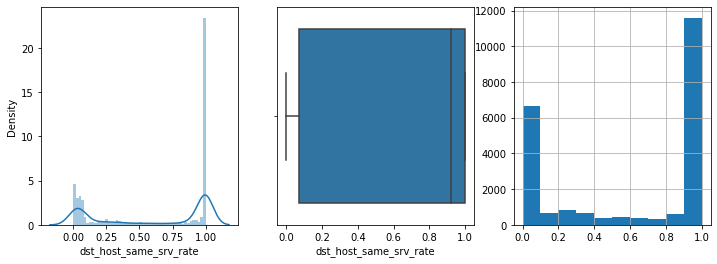

In [101]:
_ = analyzeTheFeature('dst_host_same_srv_rate')

In [102]:
df['dst_host_same_srv_rate'].value_counts()

1.00    9800
0.00    1377
0.02     869
0.07     806
0.05     754
        ... 
0.57      29
0.59      29
0.69      25
0.61      25
0.66      24
Name: dst_host_same_srv_rate, Length: 101, dtype: int64

<b>dst_host_same_srv_rate</b> appears to be a numerical attribute as it has so many unique values.  
But, it does not have any outliers.  

#### Attribute: dst_host_diff_srv_rate

Feature Info:
MIN : 0.0
MAX : 1.0
MEAN : 0.09053983321504613
Std Deviation : 0.22071684680119635
Q1 : 0.0
Q3 : 0.06
IQR : 0.06
LowerWhisker : -0.09
UpperWhisker : 0.15


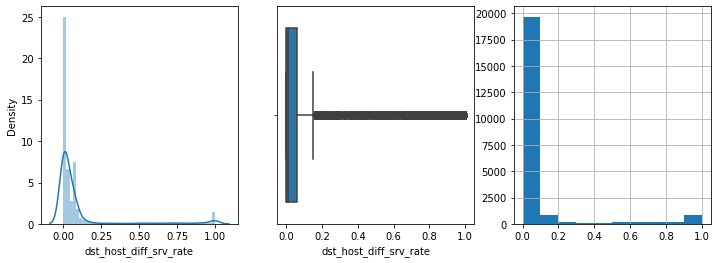

In [103]:
_ = analyzeTheFeature('dst_host_diff_srv_rate')

In [104]:
df['dst_host_diff_srv_rate'].value_counts()

0.00    9194
0.01    2085
0.02    1860
0.06    1839
0.07    1509
        ... 
0.26       6
0.41       5
0.48       5
0.46       3
0.34       2
Name: dst_host_diff_srv_rate, Length: 101, dtype: int64

<b>dst_host_diff_srv_rate</b> appears to be a numerical attribute as it has so many unique values.  

In [105]:
_ = removeTheOutliersUsingSD('dst_host_diff_srv_rate')

In [106]:
df['dst_host_diff_srv_rate'].value_counts()

0.00    9194
0.01    2085
0.02    1860
0.06    1839
0.07    1509
        ... 
0.63       6
0.41       5
0.48       5
0.46       3
0.34       2
Name: dst_host_diff_srv_rate, Length: 68, dtype: int64

#### Attribute: dst_host_same_src_port_rate

Feature Info:
MIN : 0.0
MAX : 1.0
MEAN : 0.1322609119943222
Std Deviation : 0.3062682666129218
Q1 : 0.0
Q3 : 0.03
IQR : 0.03
LowerWhisker : -0.045
UpperWhisker : 0.075


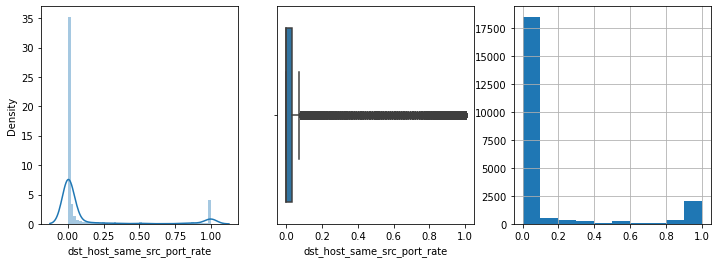

In [107]:
_ = analyzeTheFeature('dst_host_same_src_port_rate')

In [108]:
df['dst_host_same_src_port_rate'].value_counts()

0.00    12656
0.01     3234
1.00     1708
0.02      968
0.03      521
        ...  
0.70        4
0.73        4
0.68        2
0.37        2
0.66        2
Name: dst_host_same_src_port_rate, Length: 101, dtype: int64

<b>dst_host_same_src_port_rate</b> appears to be a numerical attribute as it has so many unique values.

In [109]:
_ = removeTheOutliersUsingSD('dst_host_same_src_port_rate')

In [110]:
df['dst_host_same_src_port_rate'].value_counts()

0.0000    12656
0.0100     3234
0.0465     2040
0.0200      968
0.0300      521
          ...  
0.3900        4
0.4800        4
0.6800        2
0.6600        2
0.3700        2
Name: dst_host_same_src_port_rate, Length: 93, dtype: int64

#### Attribute: dst_host_srv_diff_host_rate

Feature Info:
MIN : 0.0
MAX : 1.0
MEAN : 0.01963848474095103
Std Deviation : 0.08539388286593137
Q1 : 0.0
Q3 : 0.01
IQR : 0.01
LowerWhisker : -0.015
UpperWhisker : 0.025


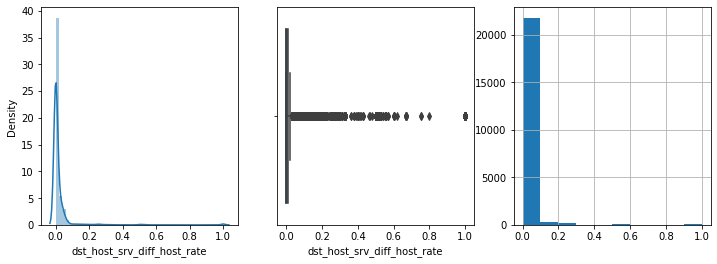

In [111]:
_ = analyzeTheFeature('dst_host_srv_diff_host_rate')

In [112]:
# df['dst_host_srv_diff_host_rate'].value_counts()

<b>dst_host_srv_diff_host_rate</b> appears to be a numerical attribute as it has so many unique values.

In [113]:
_ = removeTheOutliersUsingSD('dst_host_srv_diff_host_rate')

In [114]:
# df['dst_host_srv_diff_host_rate'].value_counts()

#### Attribute: dst_host_serror_rate

Feature Info:
MIN : 0.0
MAX : 1.0
MEAN : 0.09781360894251243
Std Deviation : 0.27313873785798337
Q1 : 0.0
Q3 : 0.0
IQR : 0.0
LowerWhisker : 0.0
UpperWhisker : 0.0


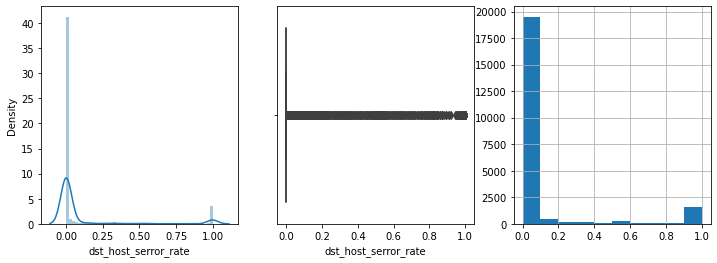

In [115]:
_ = analyzeTheFeature('dst_host_serror_rate')

In [116]:
df['dst_host_serror_rate'].value_counts()

0.00    17926
1.00     1530
0.01      660
0.02      314
0.05      142
        ...  
0.86        3
0.95        3
0.94        1
0.88        1
0.92        1
Name: dst_host_serror_rate, Length: 99, dtype: int64

<b>dst_host_serror_rate</b> appears to be a numerical attribute as it has so many unique values.

In [117]:
_ = removeTheOutliersUsingSD('dst_host_serror_rate')

In [118]:
df['dst_host_serror_rate'].value_counts()

0.0000    17926
0.0251     1695
0.0100      660
0.0200      314
0.0500      142
          ...  
0.2600        6
0.7600        6
0.4100        6
0.6600        4
0.7200        4
Name: dst_host_serror_rate, Length: 83, dtype: int64

#### Attribute: dst_host_srv_serror_rate

Feature Info:
MIN : 0.0
MAX : 1.0
MEAN : 0.09942601135557133
Std Deviation : 0.2818662789984542
Q1 : 0.0
Q3 : 0.0
IQR : 0.0
LowerWhisker : 0.0
UpperWhisker : 0.0


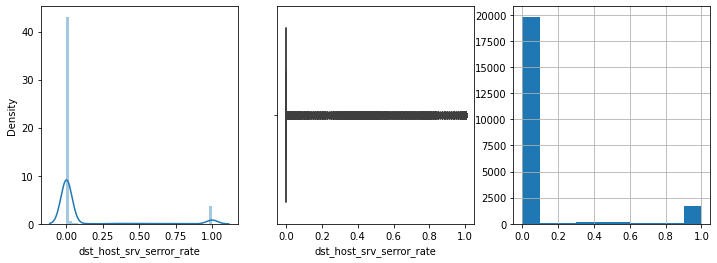

In [119]:
_ = analyzeTheFeature('dst_host_srv_serror_rate')

In [120]:
df['dst_host_srv_serror_rate'].value_counts()

0.00    18916
1.00     1694
0.01      497
0.02      214
0.03       48
        ...  
0.88        2
0.99        2
0.91        2
0.86        1
0.24        1
Name: dst_host_srv_serror_rate, Length: 101, dtype: int64

<b>dst_host_srv_serror_rate</b> appears to be a numerical attribute as it has so many unique values.

In [121]:
_ = removeTheOutliersUsingSD('dst_host_srv_serror_rate')

In [122]:
df['dst_host_srv_serror_rate'].value_counts()

0.0000    18916
0.0234     1758
0.0100      497
0.0200      214
0.0300       48
          ...  
0.1500        6
0.1400        6
0.2600        5
0.2300        4
0.2400        1
Name: dst_host_srv_serror_rate, Length: 86, dtype: int64

#### Attribute: dst_host_rerror_rate

Feature Info:
MIN : 0.0
MAX : 1.0
MEAN : 0.2333849361249113
Std Deviation : 0.38722880466757315
Q1 : 0.0
Q3 : 0.36
IQR : 0.36
LowerWhisker : -0.54
UpperWhisker : 0.9


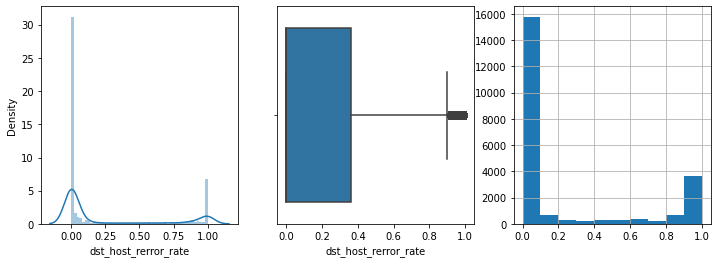

In [123]:
_ = analyzeTheFeature('dst_host_rerror_rate')

The feature <b>dst_host_rerror_rate</b> has two normal curves (as it is evident from its distribution).  
So, we will not not look for the outliers for this feature.

#### Attribute: dst_host_srv_rerror_rate

Feature Info:
MIN : 0.0
MAX : 1.0
MEAN : 0.22668293115684884
Std Deviation : 0.4008748777298267
Q1 : 0.0
Q3 : 0.17
IQR : 0.17
LowerWhisker : -0.255
UpperWhisker : 0.42500000000000004


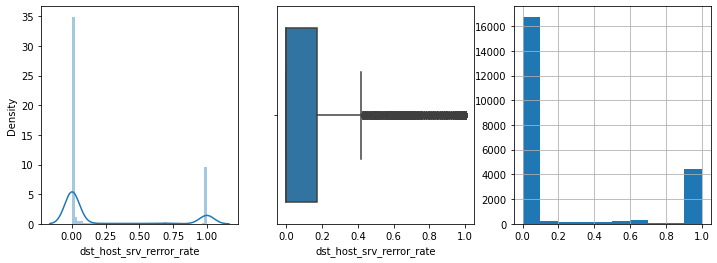

In [124]:
_ = analyzeTheFeature('dst_host_srv_rerror_rate')

The feature <b>dst_host_srv_rerror_rate</b> has two normal curves (as it is evident from its distribution).  
So, we will not not look for the outliers for this feature.

#### Attribute: protocol_type

In [125]:
# unique values for the protocol_type attribute
df['protocol_type'].value_counts(sort=True)

tcp     18880
udp      2621
icmp     1043
Name: protocol_type, dtype: int64

#### Attribute: service

In [126]:
# unique values for the service attribute
print(df['service'].value_counts(sort=True))

print()
print("Number of unique values for the service attribute:", df['service'].value_counts(sort=True).count()) #64

http       7853
private    4774
telnet     1626
pop_3      1019
smtp        934
           ... 
printer      11
ntp_u        10
rje           8
tim_i         6
tftp_u        1
Name: service, Length: 64, dtype: int64

Number of unique values for the service attribute: 64


#### Attribute: flag

In [127]:
# unique values for the flag attribute
df['flag'].value_counts(sort=True)

SF        14875
REJ        3850
S0         2013
RSTO        773
RSTR        669
S3          249
SH           73
S1           21
S2           15
OTH           4
RSTOS0        2
Name: flag, dtype: int64

#### OBSERVATIONS:
- Till this point we have seen all the available attributes of our dataset.  
- We have also identified them as Numerical and Categorical attributes.  
- For the features protocol_type, service and flag

Now we need to perform certain feature selection techniques to select some features for the feature engineering process.  
Onece this feature enginerring process gets done then only we can move ahead with model building.  

### Feature Selection
- Filter Method
- Wrapper Method
- Embedded Method
- Hybrid Method

Based on our Exploratory Data Analysis, we have identified the following categories in our dataset.  

#### Numerical Features
- duration
- src_bytes
- dst_bytes
- hot
- num_compromised
- num_root
- num_file_creations
- count
- srv_count
- serror_rate
- srv_serror_rate
- rerror_rate
- srv_rerror_rate
- same_srv_rate
- diff_srv_rate
- srv_diff_host_rate
- dst_host_count
- dst_host_srv_count  
- dst_host_same_srv_rate,
- dst_host_diff_srv_rate,
- dst_host_same_src_port_rate,
- dst_host_srv_diff_host_rate,
- dst_host_serror_rate,
- dst_host_srv_serror_rate,
- dst_host_rerror_rate,
- dst_host_srv_rerror_rate

#### Categorical Features
- wrong_fragment
- num_failed_logins
- logged_in
- root_shell
- num_access_files
- is_guest_login
- protocol_type
- service
- flag

#### Ignored Features
- land
- urgent
- su_attempted
- num_shells

In [128]:
numerical_features = ['duration',
                      'src_bytes',
                      'dst_bytes',
                      'hot',
                      'num_compromised',
                      'num_root',
                      'num_file_creations',
                      'count',
                      'srv_count',
                      'serror_rate',
                      'srv_serror_rate',
                      'rerror_rate',
                      'srv_rerror_rate',
                      'same_srv_rate',
                      'diff_srv_rate',
                      'srv_diff_host_rate',
                      'dst_host_count',
                      'dst_host_srv_count',
                      'dst_host_same_srv_rate',
                      'dst_host_diff_srv_rate',
                      'dst_host_same_src_port_rate',
                      'dst_host_srv_diff_host_rate',
                      'dst_host_serror_rate',
                      'dst_host_srv_serror_rate',
                      'dst_host_rerror_rate',
                      'dst_host_srv_rerror_rate']

categorical_features = ['wrong_fragment',
                        'num_failed_logins',
                        'logged_in',
                        'root_shell',
                        'num_access_files',
                        'is_guest_login',
                        'protocol_type', 
                        'service', 
                        'flag']

ignored_features =['land',
                   'urgent',
                   'su_attempted',
                   'num_shells']

In [129]:
df['wrong_fragment'] = df['wrong_fragment'].astype('object')
df['num_failed_logins'] = df['num_failed_logins'].astype('object')
df['logged_in'] = df['logged_in'].astype('object')
df['root_shell'] = df['root_shell'].astype('object')
df['num_access_files'] = df['num_access_files'].astype('object')
df['is_guest_login'] = df['is_guest_login'].astype('object')
df['protocol_type'] = df['protocol_type'].astype('object')
df['service'] = df['service'].astype('object')
df['flag'] = df['flag'].astype('object')

In [130]:
numerical_features_df  = df[numerical_features].copy()
print(numerical_features_df.info())
print()

categorical_features_df  = df[categorical_features].copy()
print(categorical_features_df.info())
print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22544 entries, 0 to 22543
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     22544 non-null  float64
 1   src_bytes                    22544 non-null  float64
 2   dst_bytes                    22544 non-null  float64
 3   hot                          22544 non-null  float64
 4   num_compromised              22544 non-null  float64
 5   num_root                     22544 non-null  float64
 6   num_file_creations           22544 non-null  float64
 7   count                        22544 non-null  float64
 8   srv_count                    22544 non-null  float64
 9   serror_rate                  22544 non-null  float64
 10  srv_serror_rate              22544 non-null  float64
 11  rerror_rate                  22544 non-null  float64
 12  srv_rerror_rate              22544 non-null  float64
 13  same_srv_rate   

#### Filter Method
- Removal of constant, quasi-constant and duplicate features
- Removal of Correlated features
- Using statistical methods

#### Filter out features on the basis of low variance
A feature with zero variance has the exact same value for all observations and is therefore completely uninformative.  
Here we will be looking for the features which have maximum variance of 1%, and then would drop them.

In [131]:
variance_threshold = VarianceThreshold(threshold=0.01)
variance_threshold.fit(numerical_features_df)
quasi_constant_features = numerical_features_df.columns[~variance_threshold.get_support()]
# print(quasi_constant_features)
# print(len(quasi_constant_features)) # 7
numerical_features_df = numerical_features_df.drop(columns=quasi_constant_features)

So here, based on variance threshold of 1%, we will remove or drop the following features from our dataset, since they do not contain much information.  
- num_file_creations
- serror_rate
- srv_serror_rate
- diff_srv_rate
- dst_host_diff_srv_rate
- dst_host_srv_diff_host_rate
- dst_host_serror_rate

#### Filter out features on the basis of high mutual-correlation
If two features are highly correlated with each other then having both of them in model development would make non sense.

In [132]:
def identifyHighlyCorrelatedFeatures(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                print(abs(corr_matrix.iloc[i, j]), ":", corr_matrix.columns[i], ",", corr_matrix.columns[j])
                colname = corr_matrix.columns[j]
                col_corr.add(colname)
    return col_corr

In [133]:
corr_columns = identifyHighlyCorrelatedFeatures(numerical_features_df, 0.9)
# print(corr_columns)
# print(len(corr_columns)) # 4
numerical_features_df = numerical_features_df.drop(columns=corr_columns)

0.9755351540808526 : srv_rerror_rate , rerror_rate
0.9043602221365408 : dst_host_same_srv_rate , dst_host_srv_count
0.9310253924785401 : dst_host_srv_rerror_rate , rerror_rate
0.9478491337777993 : dst_host_srv_rerror_rate , srv_rerror_rate
0.904744598844196 : dst_host_srv_rerror_rate , dst_host_rerror_rate


So here, based on the mutually-correlated features, we will remove or drop the following features from our dataset, since they do not contain much information.  
- dst_host_rerror_rate
- dst_host_srv_count
- srv_rerror_rate
- rerror_rate

#### Now lets concentrate on the categorical features
Here, we will use the one-hot-enconding for all the categorical features that would make those features numerical (compatible for ML modelling).

In [134]:
categorical_features_df = pd.get_dummies(categorical_features_df)
# categorical_features_df.info(verbose=True)

On applying one-hot encoding we have got 97 numerical features out of the 9 categorical features.  
Now we must filter out those features which have very low variance or very high mutual-correlation.

In [135]:
variance_threshold = VarianceThreshold(threshold=0.01)
variance_threshold.fit(categorical_features_df)
quasi_constant_features = categorical_features_df.columns[~variance_threshold.get_support()]
# print(quasi_constant_features)
# print(len(quasi_constant_features)) # 70
categorical_features_df = categorical_features_df.drop(columns=quasi_constant_features)
# categorical_features_df.info()

Here we have removed 70 features that have very low variance and hence they donot contribute much towards the data mining process.

In [136]:
corr_columns = identifyHighlyCorrelatedFeatures(categorical_features_df, 0.9)
print()
print(corr_columns)
categorical_features_df = categorical_features_df.drop(columns=corr_columns)
# print()
# categorical_features_df.info()

0.9946434421542505 : num_failed_logins_1.0 , num_failed_logins_0.0
1.0000000000000002 : logged_in_1.0 , logged_in_0.0
1.0000000000000004 : is_guest_login_1.0 , is_guest_login_0.0
0.9582295130744162 : service_ftp , is_guest_login_0.0
0.9582295130744174 : service_ftp , is_guest_login_1.0

{'num_failed_logins_0.0', 'logged_in_0.0', 'is_guest_login_1.0', 'is_guest_login_0.0'}


Here we have removed the another 4 features which are highly correlated with each other.

### Model Dataset (final dataset for feeding into the ML models)
Till this point we are done with our data-preprocessing, exploratory data analysis, feature selection, and feature engineering processes.   
Now we need to aggregate the different datasets into one final dataset and start the ML model building process.

In [137]:
model_dataset = pd.concat([numerical_features_df, categorical_features_df, df['class']], axis=1, join="inner")
# model_dataset.head().T
# model_dataset.shape # (22544, 39)
# model_dataset.info()

In [138]:
target = model_dataset['class'] 
encoder = LabelEncoder()
target = encoder.fit_transform(target)
#  0 for anomaly
#  1 for normal

Calculate the pearson correlation coefficient for all the features wrt the target variable. 

In [139]:
corr_dict = {}
for cols in (model_dataset.columns):
    if (cols != 'class'):
        corr, _ = pearsonr(model_dataset[cols], target)
        corr_dict[cols] = corr
# print(corr_dict)

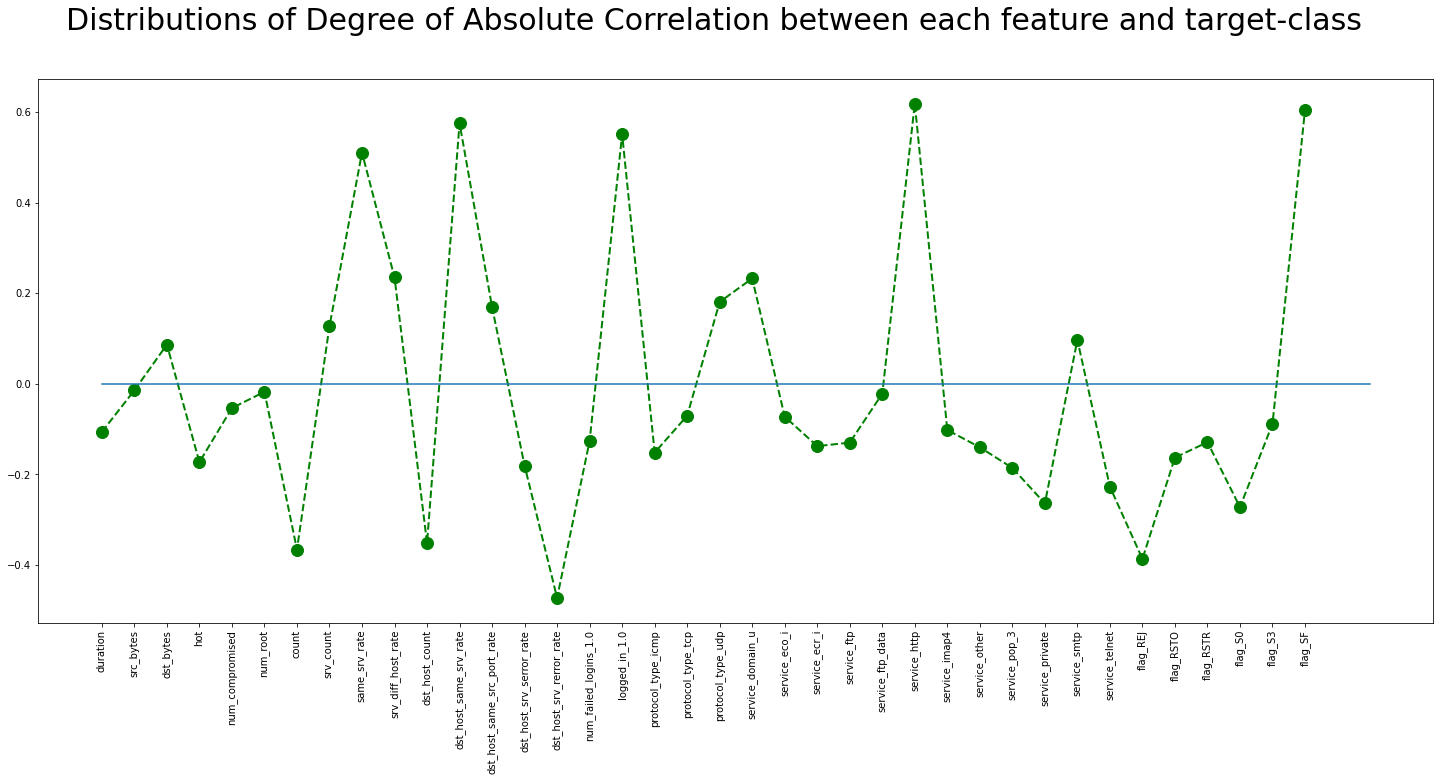

In [140]:
fig, ax = plt.subplots(figsize=(25,10))
_ = fig.suptitle('Distributions of Degree of Absolute Correlation between each feature and target-class', fontsize=30)

corr_dict_list = corr_dict.items()
x,y = zip(*corr_dict_list)
plt.xticks(rotation=90)
plt.plot(x, y, 'go--', linewidth=2, markersize=12)

# plot for "f(x)=0"
x_axis = [n for n in range(0, 40)]
y_axis = [0 for n in range(0, 40)]
plt.plot(x_axis, y_axis)

plt.show()

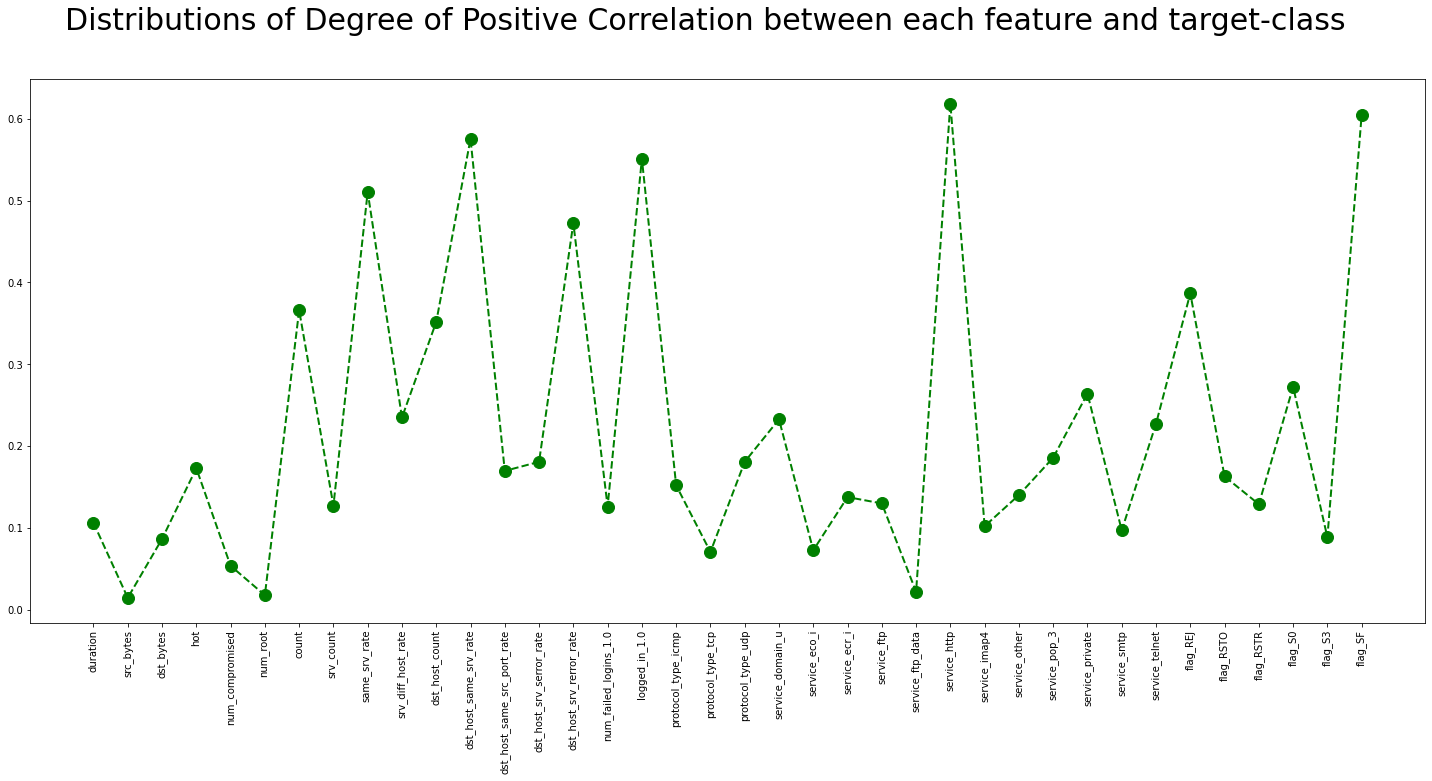

In [141]:
fig, ax = plt.subplots(figsize=(25,10))
_ = fig.suptitle('Distributions of Degree of Positive Correlation between each feature and target-class', fontsize=30)

corr_dict_list = corr_dict.items()
x,y = zip(*corr_dict_list)

y_list = list(y)
for f in range(len(y_list)):
    if (y_list[f] < 0):
        y_list[f] = y_list[f]*(-1)

plt.xticks(rotation=90)
plt.plot(x, y_list, 'go--', linewidth=2, markersize=12)
plt.show()

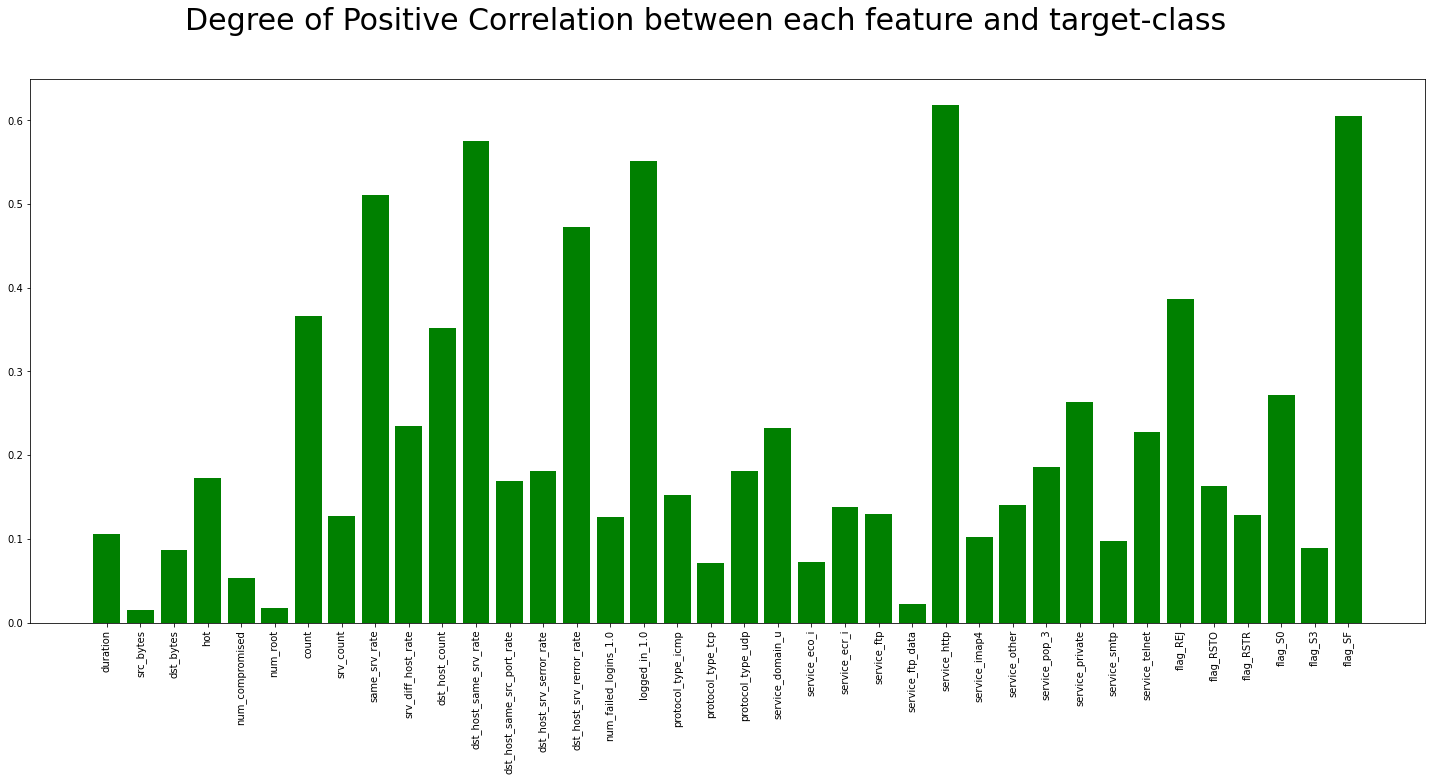

In [142]:
corr_dict_values = corr_dict.values()
corr_dict_keys = corr_dict.keys()
corr_dict_positive_values = []

for val in corr_dict_values:
    if val < 0:
        corr_dict_positive_values.append(val*(-1))
    else:
        corr_dict_positive_values.append(val)

fig, ax = plt.subplots(figsize=(25,10))
_ = fig.suptitle('Degree of Positive Correlation between each feature and target-class', fontsize=30)
plt.bar(list(corr_dict_keys), corr_dict_positive_values, color='g')
plt.xticks(rotation=90)
plt.show()

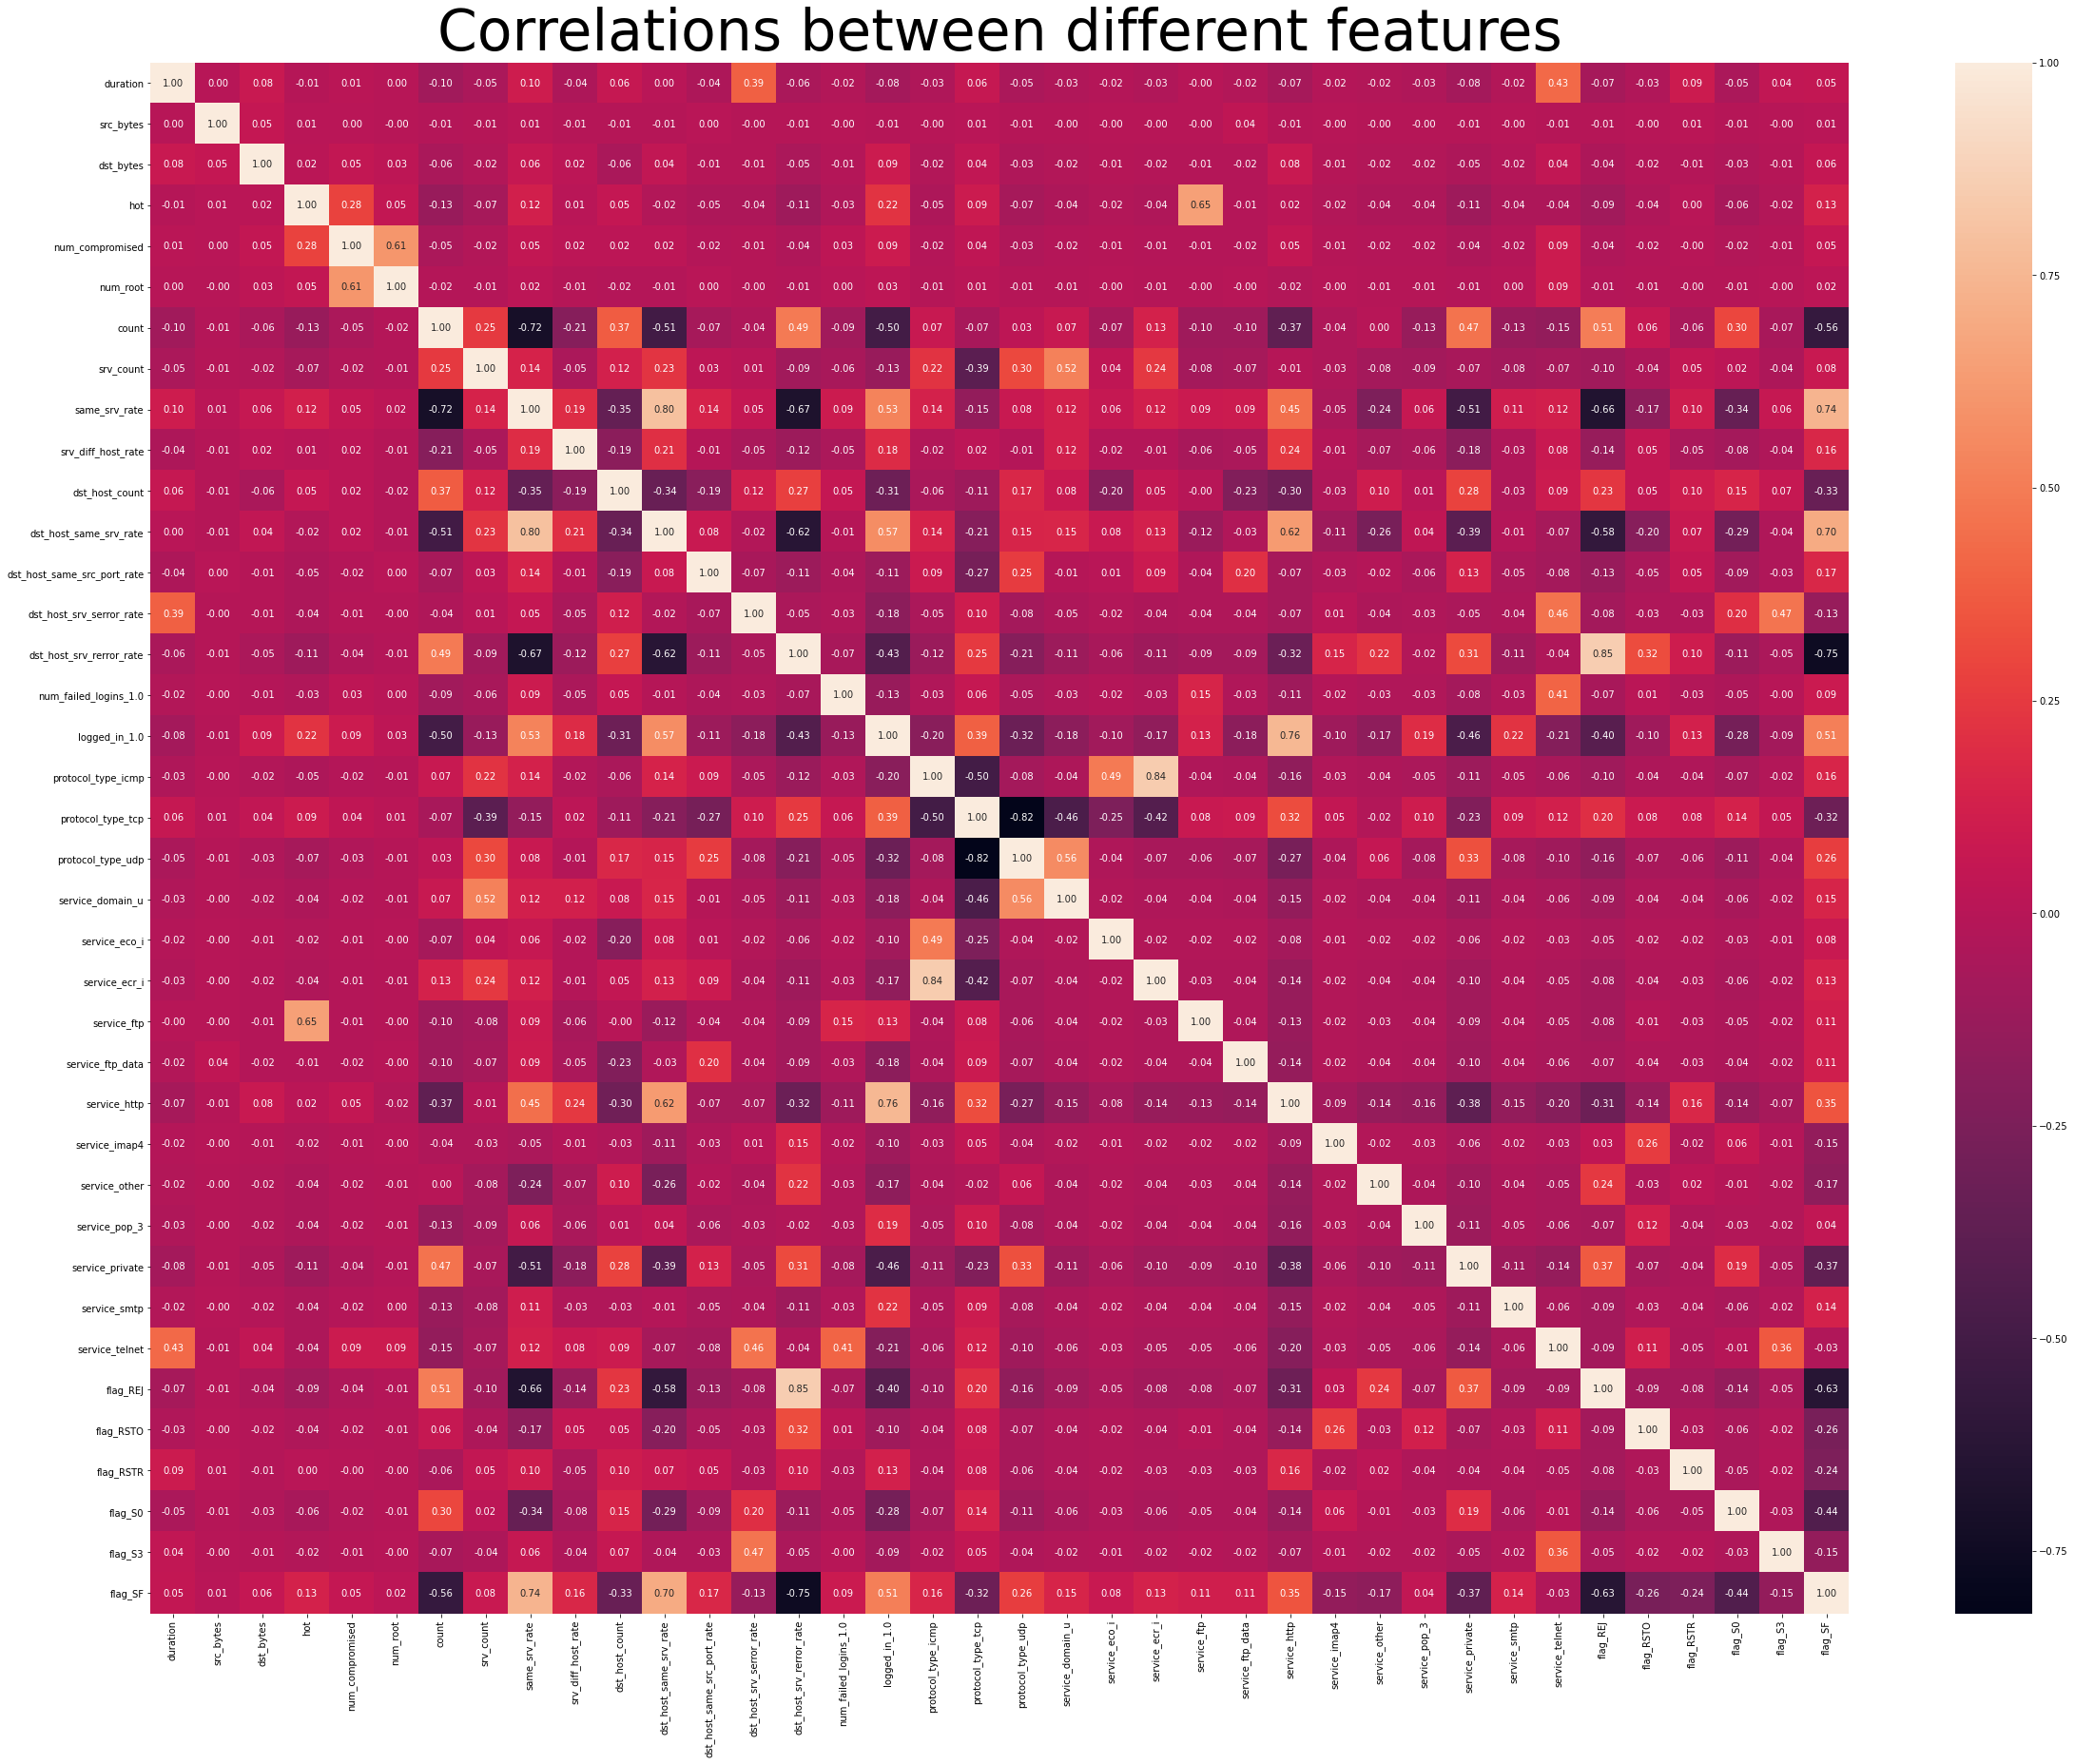

In [143]:
dataframe = model_dataset.iloc[:,:-1]
fig, ax = plt.subplots(figsize=(40, 30))
_ = sns.heatmap(dataframe.corr(), annot=True, fmt='.2f', ax=ax)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Correlations between different features', fontsize=60)
plt.show()

#### Top 11 features based on the correlation with the target variable:
- service feature having "http" as value
- flag feature having "SF" as value
- dst_host_same_srv_rate feature
- logged_in feature having "1.0" as value
- same_srv_rate feature
- dst_host_srv_rerror_rate feature
- count feature
- flag feature having "REJ" ad value
- dst_host_count feature
- flag feature having "S0" as value
- service feature having "private" as value

In [144]:
top_11_features = ['service_http', 
                   'flag_SF', 
                   'dst_host_same_srv_rate', 
                   'logged_in_1.0', 
                   'same_srv_rate', 
                   'dst_host_srv_rerror_rate',
                   'count', 
                   'flag_REJ', 
                   'dst_host_count', 
                   'flag_S0', 
                   'service_private']

corr_for_top_11_features = []
for feature in top_11_features:
    tmp = corr_dict[feature]
    if (tmp < 0):
        corr_for_top_11_features.append(tmp*-1)
    else:
        corr_for_top_11_features.append(tmp)
        
# corr_for_top_11_features

# ML Model Development

#### Now, at this point, we have our final dataset ready to be used with the machine learning algorithms.
We will first split the dependent and independent attributes.

In [145]:
X = model_dataset.iloc[:,:-1]
# X = features dataframe

Y = model_dataset.iloc[:, -1]
# X = target dataframe

# print(X.shape) # (22544, 38)
# print()
# print(Y.shape) # (22544,)

In [146]:
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)
#  0 for anomaly
#  1 for normal

#### Lets standardize the dataset

In [147]:
X_std = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)

#### Split the dataset across training and testing datasets
1. We will keep 60% of the data for the training purpose  
2. We will keep 40% of the data for the testing purpose

In [148]:
X_train, X_test, Y_train, Y_test = train_test_split(X_std, Y, test_size = 0.40, random_state = 2021)

In [149]:
# this dictionary would contain the accuracies of the different models developed on the given dataset
model_accuracy = {}

In [150]:
def performCrossValidation(model_classifier, X_train, Y_train):
    model_mean_accuracies = cross_val_score(estimator=model_classifier, X=X_train, y=Y_train, cv=10, scoring='accuracy')
    model_mean = (model_mean_accuracies.mean() * 100)
    model_stdd = (model_mean_accuracies.std() * 100)
    print("Mean Cross Validation Accuracy: {:.2f} %".format(model_mean))
    print("Std Deviation Cross Validation Accuracy: {:.2f} %".format(model_stdd))

#### Machine Learning: Decision Tree 
Decision tree is one of the predictive modelling approaches used in statistics, data mining and machine learning.  

Decision trees are constructed via an algorithmic approach that identifies ways to split a data set based on different conditions.  
It is one of the most widely used and practical methods for supervised learning.  
Decision Trees are a non-parametric supervised learning method used for both classification and regression tasks.  

Tree models where the target variable can take a discrete set of values are called classification trees.  
Decision trees where the target variable can take continuous values are called regression trees.  
Classification And Regression Tree (CART) is general term for this.  

While making decision tree, at each node of tree we ask different type of questions.  
Based on the asked question we will calculate the <b>Information Gain</b> corresponding to it.  
The <b>Information Gain</b> measures how much information a feature gives us about the class.  
The split with the highest information gain will be taken as the first split and the process will continue until all children nodes are pure, or until the information gain is 0.

In [151]:
dt_classifier = DecisionTreeClassifier(criterion='entropy', random_state=0)
dt_classifier.fit(X_train, Y_train)
Y_pred = dt_classifier.predict(X_test)
cm = confusion_matrix(Y_test, Y_pred)
dt_model_accuracy = (100 * (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]))
print("Decision Tree Model Accuracy:", dt_model_accuracy)
performCrossValidation(dt_classifier, X_train, Y_train)
model_accuracy["decision_tree_accuracy"] = dt_model_accuracy

Decision Tree Model Accuracy: 98.33666001330673
Mean Cross Validation Accuracy: 98.32 %
Std Deviation Cross Validation Accuracy: 0.17 %


#### Applying Embedded Method for Decision Tree Model

In [152]:
from sklearn.feature_selection import SelectFromModel

select_from_decison_tree = SelectFromModel(DecisionTreeClassifier(criterion='entropy', random_state=0))
select_from_decison_tree.fit(X_train, Y_train)
select_from_decison_tree.get_support()

# X_test.columns

# let's make a list and count the selected features
selected_feat = X_train.columns[(select_from_decison_tree.get_support())]
len(selected_feat)
selected_feat




Index(['duration', 'src_bytes', 'dst_bytes', 'dst_host_same_srv_rate',
       'dst_host_same_src_port_rate', 'service_domain_u', 'service_http',
       'flag_SF'],
      dtype='object')

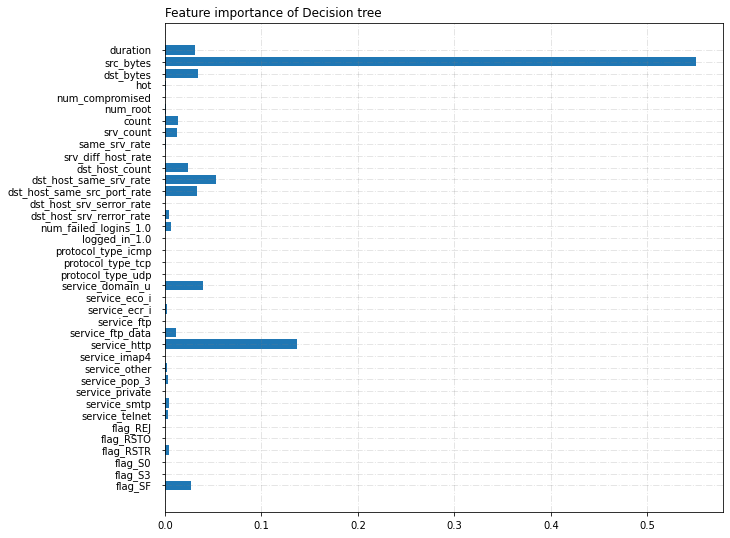

In [153]:
name = X_test.columns
price = select_from_decison_tree.estimator_.feature_importances_
fig, ax = plt.subplots(figsize =(10, 9))
ax.barh(name, price)
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
ax.grid(b = True, color ='grey',linestyle ='-.', linewidth = 1,alpha = 0.2)
ax.invert_yaxis()
ax.set_title('Feature importance of Decision tree',loc='left')
plt.show()

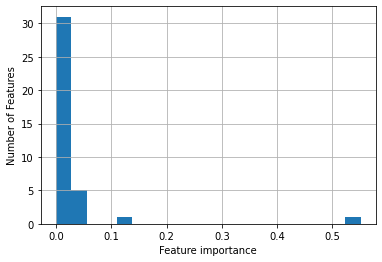

In [154]:
# and now let's plot the distribution of importances
pd.Series(select_from_decison_tree.estimator_.feature_importances_.ravel()).hist(bins=20)
plt.xlabel('Feature importance')
plt.ylabel('Number of Features')
plt.show()

#### OBSERVATIONS:
- 

#### Machine Learning: Support Vector Machine

Support Vector Machine is a supervised machine learning algorithm that can be used for both classification or regression challenges.  
However,  it is mostly used in classification problems.  
In the SVM algorithm, we plot each data item as a point in n-dimensional space (where n is a number of features you have) with the value of each feature being the value of a particular coordinate.   
Then, we perform classification by finding the hyper-plane that differentiates the two classes very well.  
  
Advantages of support vector machine :
- Support vector machine works comparably well when there is an understandable margin of dissociation between classes.
- It is more productive in high dimensional spaces.
- It is effective in instances where the number of dimensions is larger than the number of specimens.
- Support vector machine is comparably memory systematic.
- Versatile: different Kernel functions can be specified for the decision function.  
- Common kernels are provided, but it is also possible to specify custom kernels.

In [155]:
linear_svm_clf = svm.SVC(kernel='linear') # Linear Kernel
linear_svm_clf.fit(X_train, Y_train)
Y_pred = linear_svm_clf.predict(X_test)
cm = confusion_matrix(Y_test, Y_pred)
svm_model_accuracy = (100 * (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]))
print("SVM Linear Model Accuracy:", svm_model_accuracy)
performCrossValidation(linear_svm_clf, X_train, Y_train)
model_accuracy["linear_svm_accuracy"] = svm_model_accuracy

SVM Linear Model Accuracy: 94.6218673763584
Mean Cross Validation Accuracy: 94.60 %
Std Deviation Cross Validation Accuracy: 0.86 %


In [156]:
sigmoid_svm_clf = svm.SVC(kernel='sigmoid') # Sigmoid Kernel
sigmoid_svm_clf.fit(X_train, Y_train)
Y_pred = sigmoid_svm_clf.predict(X_test)
cm = confusion_matrix(Y_test, Y_pred)
svm_model_accuracy = (100 * (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]))
print("SVM Sigmoid Model Accuracy:", svm_model_accuracy)
performCrossValidation(sigmoid_svm_clf, X_train, Y_train)
model_accuracy["sigmoid_svm_accuracy"] = svm_model_accuracy

SVM Sigmoid Model Accuracy: 90.45242847638058
Mean Cross Validation Accuracy: 89.80 %
Std Deviation Cross Validation Accuracy: 1.11 %


In [157]:
poly_svm_clf = svm.SVC(kernel='poly') # Poly Kernel
poly_svm_clf.fit(X_train, Y_train)
Y_pred = poly_svm_clf.predict(X_test)
cm = confusion_matrix(Y_test, Y_pred)
svm_model_accuracy = (100 * (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]))
print("SVM Poly Model Accuracy:", svm_model_accuracy)
performCrossValidation(poly_svm_clf, X_train, Y_train)
model_accuracy["poly_svm_accuracy"] = svm_model_accuracy

SVM Poly Model Accuracy: 96.64005322687957
Mean Cross Validation Accuracy: 96.55 %
Std Deviation Cross Validation Accuracy: 0.42 %


In [158]:
rbf_svm_clf = svm.SVC(kernel='rbf') # RBF Kernel
rbf_svm_clf.fit(X_train, Y_train)
Y_pred = rbf_svm_clf.predict(X_test)
cm = confusion_matrix(Y_test, Y_pred)
svm_model_accuracy = (100 * (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]))
print("SVM RBF Model Accuracy:", svm_model_accuracy)
performCrossValidation(rbf_svm_clf, X_train, Y_train)
model_accuracy["rbf_svm_accuracy"] = svm_model_accuracy

SVM RBF Model Accuracy: 96.66223109336882
Mean Cross Validation Accuracy: 96.38 %
Std Deviation Cross Validation Accuracy: 0.51 %


#### Accuracy comparison of different ML models

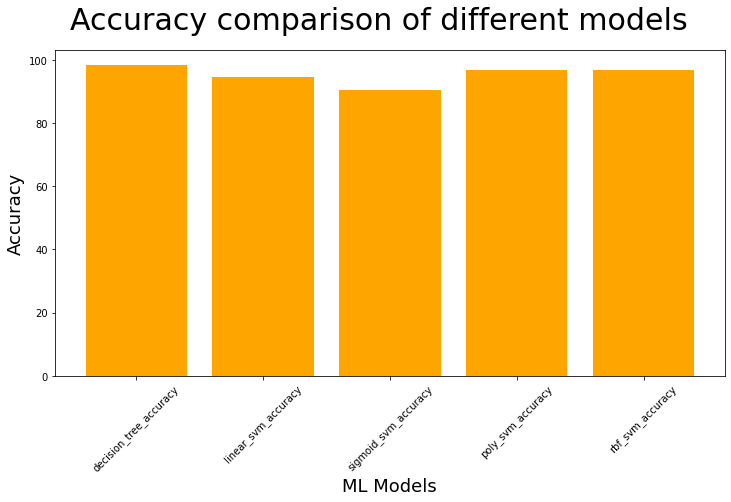

In [159]:
model_accuracy_keys = model_accuracy.keys()
model_accuracy_values = model_accuracy.values()

fig, ax = plt.subplots(figsize=(12,6))
_ = fig.suptitle('Accuracy comparison of different models', fontsize=30)
plt.bar(model_accuracy_keys, model_accuracy_values, color='orange')
plt.xticks(rotation=45)
plt.ylabel("Accuracy", fontsize=18)
plt.xlabel("ML Models", fontsize=18)
plt.show()

#### Applying Embedded Method for SVM Model

<AxesSubplot:>

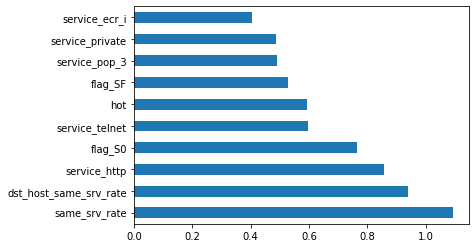

In [160]:
_ = linear_svm_clf.coef_
pd.Series(abs(linear_svm_clf.coef_[0]), index=X_test.columns).nlargest(10).plot(kind='barh')

In [161]:
# _ = sigmoid_svm_clf.coef_
# pd.Series(abs(sigmoid_svm_clf.coef_[0]), index=X_test.columns).nlargest(10).plot(kind='barh')

In [162]:
# _ = poly_svm_clf.coef_
# pd.Series(abs(poly_svm_clf.coef_[0]), index=X_test.columns).nlargest(10).plot(kind='barh')

In [163]:
# _ = rbf_svm_clf.coef_
# pd.Series(abs(rbf_svm_clf.coef_[0]), index=X_test.columns).nlargest(10).plot(kind='barh')

### Top features for model building

Top 5 features for model building

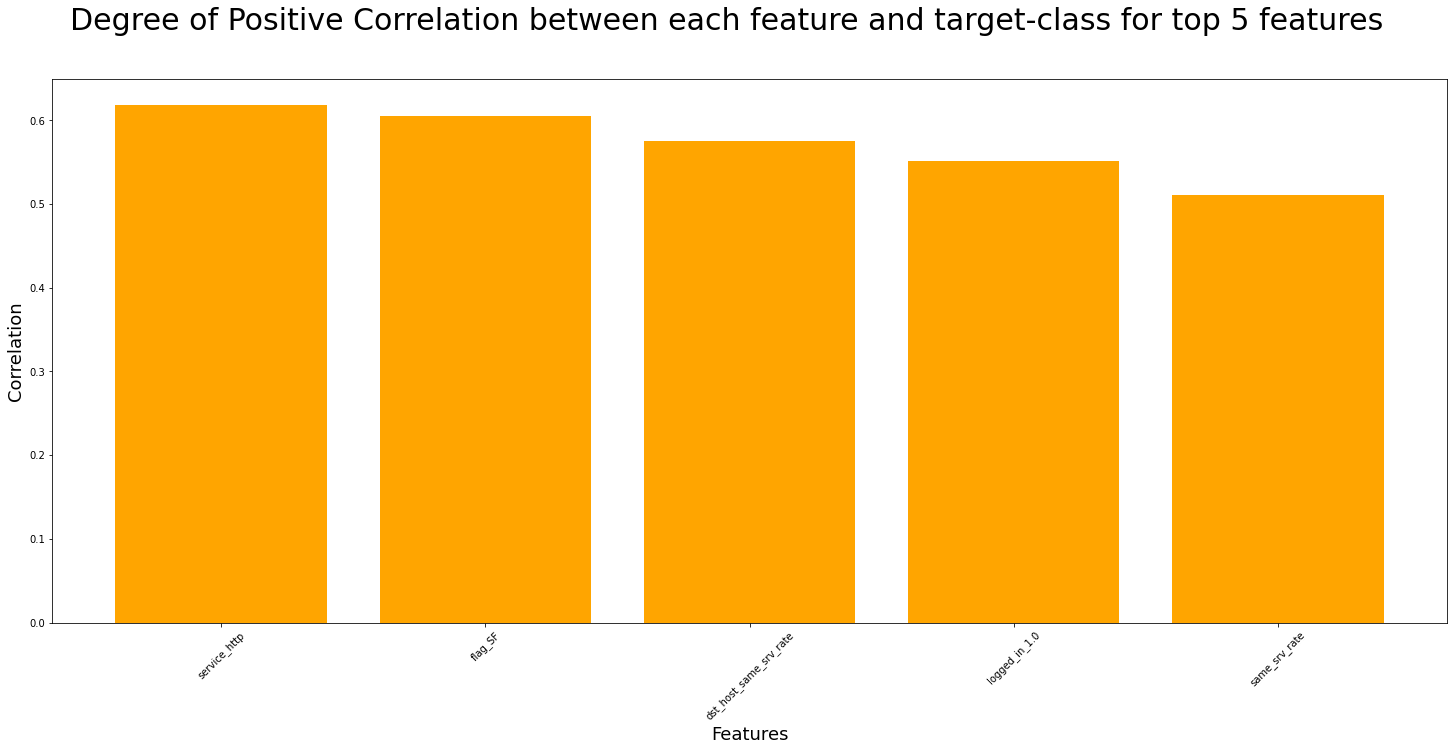

In [164]:
top_5_features = [ 'service_http', 
                   'flag_SF', 
                   'dst_host_same_srv_rate', 
                   'logged_in_1.0', 
                   'same_srv_rate']


corr_for_top_5_features = corr_for_top_11_features[0:5]

fig, ax = plt.subplots(figsize=(25,10))
_ = fig.suptitle('Degree of Positive Correlation between each feature and target-class for top 5 features', fontsize=30)
plt.bar(top_5_features, corr_for_top_5_features, color='orange')
plt.xticks(rotation=45)
plt.ylabel("Correlation", fontsize=18)
plt.xlabel("Features", fontsize=18)
plt.show()

Top 6 features for model building

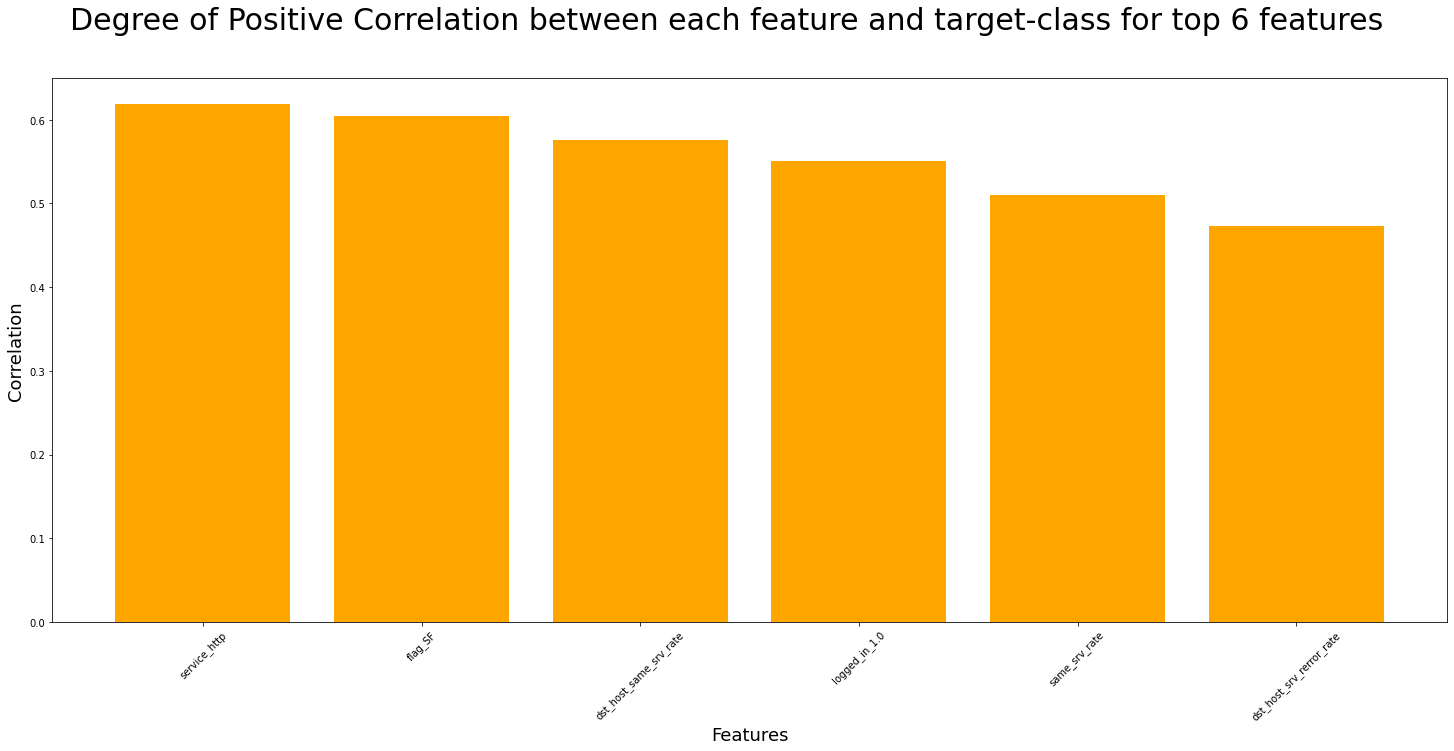

In [165]:
top_6_features = ['service_http', 
                   'flag_SF', 
                   'dst_host_same_srv_rate', 
                   'logged_in_1.0', 
                   'same_srv_rate', 
                   'dst_host_srv_rerror_rate']

corr_for_top_6_features = corr_for_top_11_features[0:6]

fig, ax = plt.subplots(figsize=(25,10))
_ = fig.suptitle('Degree of Positive Correlation between each feature and target-class for top 6 features', fontsize=30)
plt.bar(top_6_features, corr_for_top_6_features, color='orange')
plt.xticks(rotation=45)
plt.ylabel("Correlation", fontsize=18)
plt.xlabel("Features", fontsize=18)
plt.show()

Top 8 features for model building

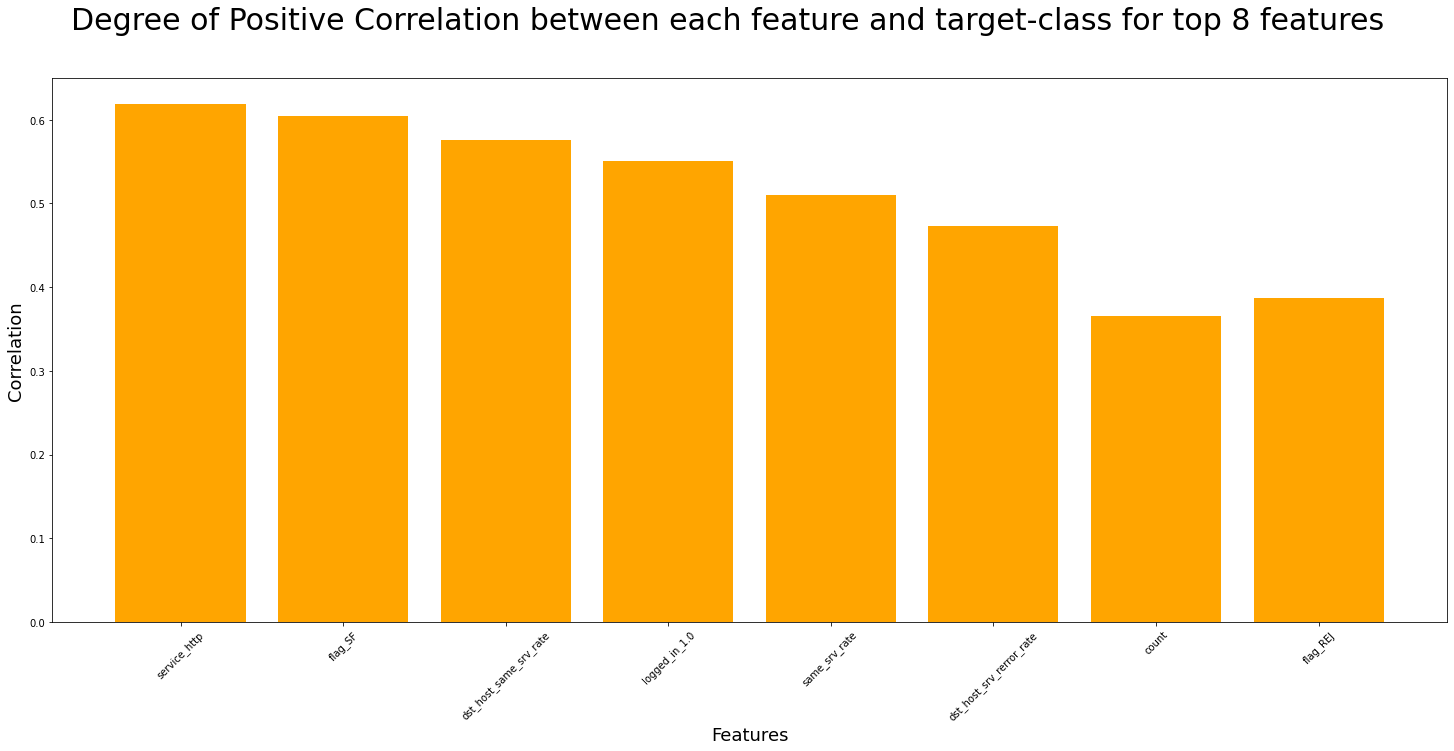

In [166]:
top_8_features = ['service_http', 
                   'flag_SF', 
                   'dst_host_same_srv_rate', 
                   'logged_in_1.0', 
                   'same_srv_rate', 
                   'dst_host_srv_rerror_rate',
                   'count', 
                   'flag_REJ']

corr_for_top_8_features = corr_for_top_11_features[0:8]

fig, ax = plt.subplots(figsize=(25,10))
_ = fig.suptitle('Degree of Positive Correlation between each feature and target-class for top 8 features', fontsize=30)
plt.bar(top_8_features, corr_for_top_8_features, color='orange')
plt.xticks(rotation=45)
plt.ylabel("Correlation", fontsize=18)
plt.xlabel("Features", fontsize=18)
plt.show()

### Conclusion
- src_bytes contributes maximum towards the DT model

### Suggestion 
- Different ML algorithms should be applied over the same post-processed dataset, like KNN, Logistic Regression, Random Forest etc  


### THE END